# Group: 41 (Boris, Niklas, Philipp)

# Homework 2

The purpose of this homework is to get acquainted with the solution of linear systems using elementary methods. As a model problem, we will work with polynomial interpolation. We will also use this homework as an opportunity to examine and familiarize ourselves with the Numpy library for Python, which makes it extremely easy to work with arrays in general, and vectors and matrices in particular.

- - -

<div class="alert alert-info">

### NumPy and Linear Algebra in Python
</div>

There are several excellent sources of documentation for Numpy.

<div class="alert alert-success">
    
**Task 1:** Familiarize yourself with Numpy by reading the [quickstart tutorial](https://docs.scipy.org/doc/numpy/user/quickstart.html):
- In particular, since we will be working with matrices (two-dimensional arrays), make sure you understand indexing and slicing.
- Also, be aware of the semantics of assignments (view vs. copy), which is sometimes tricky for beginners. More [here](https://numpy.org/doc/stable/user/basics.copies.html), [here](https://www.w3schools.com/python/numpy/numpy_copy_vs_view.asp) and [here](https://scipy-cookbook.readthedocs.io/items/ViewsVsCopies.html).
</div>

Let's get started by importing the relevant packages and doing some basic setup.

In [20]:
import numpy as np              # basic arrays, vectors, matrices
import numpy.linalg as la       # linear algebra functions
import matplotlib.pyplot as plt # plotting
from scipy import linalg

%matplotlib inline

- - -

<div class="alert alert-info">

### Polynomial Interpolation
</div>

*Interpolation* refers to the process of extrapolating from discrete measurements to a continuous function. A model problem is for example to compute the continuous trajectory $x(t)$ of an object over time from discrete snapshots $(t_i,x_i)$. *Polynomial interpolation* specifically refers to describing the continuous function as a polynomial.

Formally, the (one-dimensional) polynomial interpolation problem is described as follows: given a sequence of $n$ $x$-coordinates $(x_0,\dots,x_n)$ with $x_i \neq x_j$ if $i\neq j$ and corresponding values $y_i \in \mathbb{R}$, determine a polynomial $p(x)$ of degree $n$ such that

$$
p(x_i)\ =\ a_n x^n + a_{n-1} x^{n-1} + \cdots + a_1 x + a_0\ \stackrel{!}{=}\ y_i,\ \ i=0,\dots,n.
$$

This problem can be turned into a linear system, as follows:

Let $v_j$ the vector of powers of $v_j$, i.e. 

$$v_j = (1, x_j, x_j^2, \dots, x_j^n)^T,$$ 

and let $a = (a_0, a_1, \dots, a_n)^T$ the vector of coefficients of $p$. Then, the interpolation condition $p(x_i) = y_i$ can be written as the scalar product of $q_i$ and $a$, since

$$
p(x_i)\ =\ a_n x_i^n + \cdots + a_1 x_i + 1 \cdot a_0 = \ a^T v_i\  \stackrel{!}{=} y_i
$$

Repeating this for $i=0,\dots,n$, we obtain a linear system for the coefficients:

$$
\begin{pmatrix}
1 & x_0 & x_0^2 & \cdots & x_0^n \\
1 & x_1 & x_1^2 & \cdots & x_1^n \\
1 & x_2 & x_2^2 & \cdots & x_2^n \\
\vdots & \vdots &\vdots &\vdots & \\
1 & x_n & x_n^2 & \cdots & x_n^n \\
\end{pmatrix}
\begin{pmatrix} a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_n\end{pmatrix} =
\begin{pmatrix} y_0 \\ y_1 \\ y_2 \\ \vdots \\ y_n\end{pmatrix}
\qquad
$$

or briefly using matrix notation

$$V a = y$$

The $(n+1)\times (n+1)$ system matrix $V$ with $V_{ij} = x_i^j$ is called a *Vandermonde matrix*. A solution of the corresponding system gives the coefficients $a$ of the polynomial $p$.

Let's consider a specific problem instance: first, define NumPy arrays containing the data $x_i$ and $y_i$:

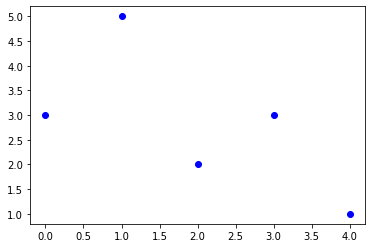

In [2]:
n = 4
y = np.array( [3., 5, 2, 3, 1] )
x = np.array( [0., 1, 2, 3, 4] )

plt.plot( x, y, 'bo' );

Graphically, our goal is to construct a polynomial of degree $4$ (since there are five points) that exactly passes through these points. 

(You have encountered this problem previously when constructing a line (= polynomial of degree one) given two points, or a parabola (= polynomial of degree two) that passes through three given points.

We begin by constructing the Vandermonde system matrix for the $x_i$. Naively, we would write

In [4]:
V = np.empty( (n+1, n+1) )


# directly fill in matrix entries
for i in range(n+1):
    for j in range(n+1):
        V[i,j] = x[i]**j
        
V

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

However, we can write this a little more compactly using a list comprehension:

In [5]:
# create a 2D array whose rows are the powers of x,
# then transpose so the columns are the powers of x
V = np.array( [x**p for p in range(n+1)] )
V

array([[  1.,   1.,   1.,   1.,   1.],
       [  0.,   1.,   2.,   3.,   4.],
       [  0.,   1.,   4.,   9.,  16.],
       [  0.,   1.,   8.,  27.,  64.],
       [  0.,   1.,  16.,  81., 256.]])

Even shorter: NumPy directly offers the [`vander`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vander.html) function for constructing $V$. By default, `vander` constructs the matrix such that the powers decrease along the rows of $V$; we thus need to pass `increasing=True` to match the order of $a$ we defined above.

In [6]:
V = np.vander( x, increasing=True )
V

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

Now we can solve the system $Va = y$ for $a$ to obtain the coefficients of the polynomial $p$.

- - -

<div class="alert alert-info">
    
### Gauss Elimination
</div>

As discussed in the lecture, the Gauss elimination algorithm can be used to solve the system above.

<div class="alert alert-success">
    
**Task 2:** Implement the Gauss algorithm (without pivoting) in two steps through the below functions:
- `bwd_subs` should perform backward substitution to solve an upper tridiagonal system
- `gauss_solve` should reduce the extended matrix $(A,b)$ to upper tridiagonal form via Gauss elimination, and then use `bwd_subs` to solve the system
- It is always sensible to think about ways to validate your implementations, e.g. check that `bwd_subs` does the right thing.
</div>

In [7]:

def bwd_subs( a,b ):
        
    """Solve the linear system Ux = y with upper triangular matrix U by backward substitution."""
    n = len(b)
    x = np.zeros(n)
    x[n-1] = b[n-1]/a[n-1, n-1]
    for i in range(n-1,-1,-1):
        Sum = b[i]
        for j in range(i+1,n):
            Sum = Sum - a[i,j]*x[j]
        x[i] = Sum/a[i,i]
    
    
    # TO DO

        
    return x

def gauss_solve( a, b ):
    """Solve the linear system Ax=b using direct Gaussian elimination and backward substitution."""
    
    n = len(b)
    # TO DO
    for k in range(n-1):
        for i in range(k+1, n):
            factor = a[i,k]/a[k,k]
            for j in range(k,n):
                a[i,j] = a[i,j]- factor*a[k,j]
            b[i] = b[i] - factor*b[k]
    print(a,b)
    return bwd_subs(a,b)
   
'''
V = np.array([[1,2,4],[3,5,9],[3,5,5]])
y = np.array([5,4,8])


gauss_solve(V,y)
bwd_subs(V,y)
print('The solution of the system:')
print(bwd_subs(V,y))
print(gauss_solve(V,y))
'''

"\nV = np.array([[1,2,4],[3,5,9],[3,5,5]])\ny = np.array([5,4,8])\n\n\ngauss_solve(V,y)\nbwd_subs(V,y)\nprint('The solution of the system:')\nprint(bwd_subs(V,y))\nprint(gauss_solve(V,y))\n"

Let's apply this to our problem and validate the solution graphically. NumPy conveniently provides the [`polyval`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyval.html) function to evaluate the found polynomial. 

A potential showstopper is that `polyval` requires as input the coefficients in descending order (i.e. `a[0]` as the coefficient of $x^n$), while we compute them in ascending order (`a[n]` is the coefficient of $x^n$). This is however easily remedied using NumPy's [`flip`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html?highlight=flip#numpy.flip) function.

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.]
 [ 0.  0.  2.  6. 14.]
 [ 0.  0.  0.  6. 36.]
 [ 0.  0.  0.  0. 24.]] [  3.   2.  -5.   9. -16.]
[  3.          11.5        -14.33333333   5.5         -0.66666667]


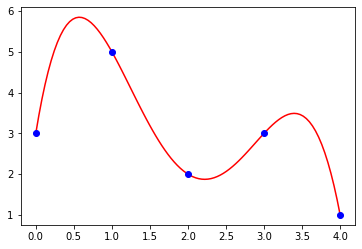

In [8]:
a = gauss_solve( V, y )
print(a)

y = np.array( [3., 5, 2, 3, 1] )
x = np.array( [0., 1, 2, 3, 4] )
# plot output
xx = np.linspace( x.min(), x.max(), 100 )
yy = np.polyval( np.flip(a), xx )


plt.plot( xx, yy, 'r-', x, y, 'bo' );

Problem solved! (... if you completed task 2.)

- - -

<div class="alert alert-info">
    
### LU Decomposition
</div>

While Gauss elimination works well for a small number of points, for a large number of points it does not work well. Let's look at a larger problem instance:

[[ 1.00000000e+00 -1.00000000e+00  1.00000000e+00 ... -1.00000000e+00
   1.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  4.08163265e-02 -7.99666805e-02 ...  8.58946599e-01
  -8.64703881e-01  8.70226171e-01]
 [ 0.00000000e+00  0.00000000e+00  3.33194502e-03 ... -7.36164622e-01
   7.46187640e-01 -7.55862436e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00 -4.44089210e-16 ... -1.10975525e-02
  -1.78081515e-02  2.40728325e-02]
 [ 0.00000000e+00  0.00000000e+00  4.44089210e-16 ...  0.00000000e+00
   5.34113643e-02 -9.20820070e-02]
 [ 0.00000000e+00  0.00000000e+00  4.44089210e-16 ...  2.22044605e-16
   0.00000000e+00  5.37934962e-02]] [-7.59687913e-01  1.09003110e+00 -4.23951418e-01 -7.10874888e-01
  1.31288423e+00 -9.03623053e-01 -1.18481245e-01  9.67147206e-01
 -1.13193049e+00  6.41948505e-01  1.05807009e-01 -6.77302731e-01
  8.39285957e-01 -6.00885682e-01  1.82872981e-01  2.64727193e-01
 -1.34372295e+00 -3.83784603e-01  5.87468370e-01  1.21105068e+00
 -5.18951126e-01 -6.85851195e-02  1.218

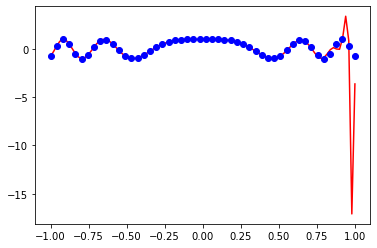

In [9]:
n = 50
x = np.linspace( -1, 1, n )
y = np.cos( 15*x**2 )

# set up system matrix
V = np.vander( x, increasing=True )
a = gauss_solve( V, y )

# plot output
x = np.linspace( -1, 1, n )
y = np.cos( 15*x**2 )
xx = np.linspace( x.min(), x.max(), 100 )
yy = np.polyval( np.flip(a), xx )

plt.plot( xx, yy, 'r-', x, y, 'bo' );

This does not look entirely right. In order to quantify the error, we can compute the norm of the *residual* vector: 

$$r := y - Va $$

In [10]:
la.norm(y- np.matmul(V, a))

839.0914436793852

and see that it is not actually small. 

The reason that the residual is so large lies in the ill-conditioned nature of the system matrix. NumPy gives us an easy way to compute the condition number of the system matrix, which indicates how much small errors are amplified when solving the system:

In [11]:
la.cond( V )

13481681380360.158

That is a big number. While the Gauss algorithm works well for well-conditioned problems, it is not stable enough to address severely ill-conditioned problems; hence it does not work well here.

**Aside**: It is easy to see that the condition number increases rapidly with $n$:

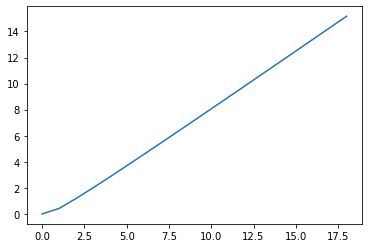

In [12]:
plt.plot( [np.log10(la.cond(np.vander(np.linspace(0,1,n)))) for n in range(1,20)] );

As the number of points increases, the columns of the Vandermonde matrix become more and more similar and thus less and less linear independent; for 10 points, the condition number is already $\approx 10^8$. In a sense, the system becomes more and more difficult to solve, leading to increasing problems in the application of numerical techniques. (This is quite typical behavior for many important numerical problems / techniques.)

To remedy this, let's apply the LU decomposition with partial pivoting to solve this system. The purpose of the pivoting is to increase the numerical stability of the algorithm.

<div class="alert alert-success">

**Task 3**: implement routines `lu_factor`, `fwd_subs` and `lu_solve` below for computing and using the LU decomposition with partial pivoting
</div>

In [13]:
def lu_factor(A):
    """Perform an LU decomposition PA = LU with partial pivoting of the square matrix A."""
    n=A.shape[0]
    perm = np.array(range(n))
    P = np.eye(n)
    for k in range(n-1):
        pivot_row = k
        abs_u_ik_max = abs(A[perm[k],k])
        for row in range(k+1, n):
            abs_u_ik = abs(A[perm[row],k])
            if abs_u_ik > abs_u_ik_max:
                pivot_row = row
                abs_u_ik_max = abs_u_ik
        if pivot_row > k: 
            (perm[k], perm[pivot_row]) = (perm[pivot_row], perm[k])
        else:
            for row in range(n):
                permA = np.vstack([A[perm[row],:]] for row in range(n))   #Fehlermeldung, funktioniert trotzdem
                P = np.vstack([P[perm[row],:]] for row in range(n))
                    
    U=np.copy(permA)
    L=np.eye(n)
    for i in range(n):
        p=U[i,i]
        for j in range(i+1,n):
            L[j,i]=U[j,i]/p
            U[j]=U[j]-L[j,i]*U[i]
   

    return (P, L, U)


def fwd_subs( a, b ):
    """Solve the linear system Ly = b with lower triangular matrix L by forward substitution."""
    n = len(b)
    x = np.zeros(n)

    x[0] = b[0]/a[0, 0]
    for i in range(1,n,1):
        Sum = b[i]
        for j in range(i-1,n):
            Sum = Sum - a[i,j-1]*x[j-1]
        x[i] = Sum/a[i,i]      
    
        
    return y


def lu_solve(P, L, U, b):
    """Solve the linear system Ax = b with upper/lower triangular matrices U, L and
       permutation matrix P."""
    
    # TO DO
    a = P @ L @ U
    
    n = len(b)
    x = np.zeros(n)
    x[0] = b[n-1]/a[0,n-1]
    
    for i in range(n-2, -1,-1):
        Sum = b[i]
        for j in range(0,n-1):
            Sum = Sum - a[i,j]*x[j]
            
        x[i] = Sum
    x[n-1] = b[n-1]/a[0,n-1]
    x = np.flip(x)
           
    return x
    

Let's apply this to our problem:

C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  permA = np.vstack([A[perm[row],:]] for row in range(n))   #Fehlermeldung, funktioniert trotzdem
C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  P = np.vstack([P[perm[row],:]] for row in range(n))


residual =  12.005107498785192


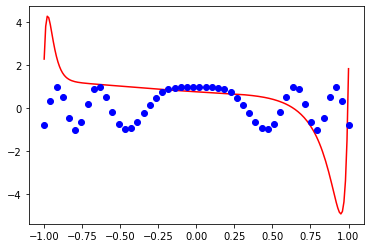

In [14]:
n = 50
x = np.linspace( -1, 1, n )
y = np.cos( 15*x**2 )

# set up system matrix
V = np.vander( x, increasing=True )

P,L,U = lu_factor(V)
a = lu_solve(P,L,U,y)

print( "residual = ", la.norm( y- np.matmul(V, a)) )

# plot output
xx = np.linspace( x.min(), x.max(), 200 )
yy = np.polyval( np.flip(a), xx )

plt.plot( xx, yy, 'r-', x, y, 'bo' );

In [26]:
U

array([[ 1.00000000e+00, -1.00000000e+00,  1.00000000e+00, ...,
        -1.00000000e+00,  1.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  2.00000000e+00,  0.00000000e+00, ...,
         2.00000000e+00,  0.00000000e+00,  2.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -7.99666805e-02, ...,
        -8.18130273e-01, -8.64703881e-01, -8.29409845e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00, -3.26144113e-16, ...,
        -2.38784321e-12,  3.82403911e-12, -1.13866840e-11],
       [ 0.00000000e+00,  0.00000000e+00, -3.06868604e-16, ...,
         0.00000000e+00, -4.67806803e-12, -1.85677798e-12],
       [ 0.00000000e+00,  0.00000000e+00, -2.61428039e-16, ...,
         0.00000000e+00,  0.00000000e+00, -6.76074153e-12]])

- - - 

<div class="alert alert-info">

### Microbenchmarks
</div>

Beyond numerical stability from pivoting, the LU decomposition also has one other advantage: the elimination work is captured in $L$ and $U$ and does not have to be repeated if the same linear system must be solved repeatedly for different right-hand sides.

This is a good opportunity to use a *microbenchmark* to quickly get an idea whether this is true in practice. Let's create one using Jupyter's [`%%timeit`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) magic that measures the runtime of a single cell. First, set up a test problem, using again polynomial interpolation:

In [15]:
n = 40
x = np.linspace( 0, 1, n )

# set up the system matrix
V = np.vander( x, increasing=True )

# create m random right-hand sides
m = 500
y = np.random.random(size=(m,n))
print(y)

[[0.32978654 0.10136808 0.84771374 ... 0.42689025 0.14000287 0.61919959]
 [0.15819756 0.21414925 0.49643746 ... 0.15063771 0.95908321 0.18919437]
 [0.67127086 0.33563547 0.78086423 ... 0.8852459  0.21816602 0.6094617 ]
 ...
 [0.91650968 0.02919237 0.84620101 ... 0.89153761 0.60241233 0.22863036]
 [0.71578318 0.14687924 0.63343199 ... 0.06944598 0.6209871  0.36779199]
 [0.82303124 0.12666533 0.35680723 ... 0.26261099 0.18534293 0.02424036]]


Now, we can measure the time required to do one decomposition and $m$ solutions:

In [16]:
%%timeit

P,L,U = lu_factor(V)
for b in y:
    a = lu_solve(P,L,U, b)

C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  permA = np.vstack([A[perm[row],:]] for row in range(n))   #Fehlermeldung, funktioniert trotzdem
C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  P = np.vstack([P[perm[row],:]] for row in range(n))
C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  x[0] = b[n-1]/a[0,n-1]
C:\Users\phili\AppData\Local\Temp/ipykernel_14584/1053293460.py:63: RuntimeWarning: invalid value encountered in double_scalars
  

409 ms ± 38.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<div class="alert alert-success">

**Task 4**: Run the following microbenchmark that uses `gauss_solve` to solve the system for each right-hand side, and compare with the previous time measurement where the LU decomposition was used.
</div>

In [17]:
%%timeit

for b in y:
    a = gauss_solve( V, b )
    

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023475e-12
  -3.85659087e-11 -1.92955064e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257792e-11  2.90580362e-10]
 [ 0.00000000e+00  0.00000000e+00 -1.11022302e-16 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [ 3.29786541e-01 -2.28418462e-01  9.74764123e-01 -1.83932390e+00
  2.63689285e+00 -3.43276470e+00  5.02052944e+00 -1.00551739e+01
  2.51922496e+01 -6.49821612e+01  1.59531205e+02 -3.70577336e+02
  8.24795412e+02 -1.77839295e+03  3.73183581e+03 -7.61365522e+03
  1.50369520e+04 -2.85754929e+04  5.18488591e+04 -8.88099732e+04
  1.40597404e+05 -1.95013806e+05  1.919

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.20710172 0.66375614 0.7662398  0.43379305 0.89756699 0.75767526
 0.47926175 0.9066575  0.12134115 0.44941907 0.64766901 0.18878006
 0.23056462 0.94689613 0.13044605 0.93065594 0.15377872 0.59416898
 0.00576542 0.25468438 0.21369547 0.21382619 0.78821164 0.6454395
 0.98208945 0.70592567 0.49071584 0.84004776 0.00222969 0.31155939
 0.82506907 0.93540486 0.59181

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.0594887  0.83637107 0.11372894 0.70405837 0.24076994 0.06281594
 0.81505014 0.21726391 0.73936034 0.83483908 0.33804686 0.03610592
 0.85680041 0.13390511 0.92180039 0.50170016 0.96826425 0.5722546
 0.01807561 0.22245353 0.99572474 0.73612388 0.22530916 0.83530344
 0.17833037 0.23893673 0.33434157 0.21037806 0.15649327 0.1956717
 0.45941855 0.32149106 0.068270

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.89393982 0.43755821 0.57310505 0.41042417 0.40496052 0.73468586
 0.81578872 0.31705358 0.33752728 0.75133094 0.28322723 0.33013604
 0.11039413 0.57396641 0.67582254 0.35051136 0.22367319 0.64610747
 0.83077507 0.3309441  0.96771685 0.53082967 0.62849129 0.43176329
 0.95697089 0.8734767  0.2348691  0.46133962 0.53959021 0.45217002
 0.22483595 0.11508484 0.5397

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.65274274 0.07304579 0.1381005  0.48166367 0.7943709  0.04993495
 0.84901805 0.72092308 0.42506908 0.21746687 0.0248845  0.42138684
 0.67803092 0.44095275 0.68284151 0.00954213 0.59514092 0.4421663
 0.51485985 0.87587163 0.4262016  0.25314098 0.11863481 0.88188566
 0.66390166 0.74604777 0.03537234 0.59621525 0.69128481 0.30738954
 0.20019736 0.50427529 0.59440

   0.00000000e+00  1.68457764e-11]] [0.38722529 0.78387122 0.31884333 0.19577947 0.88702554 0.99503049
 0.22326039 0.40436173 0.42049406 0.94367203 0.69176962 0.05359999
 0.38132814 0.31582366 0.77362471 0.14340922 0.82106097 0.9040192
 0.09497046 0.19733437 0.04388567 0.62323916 0.93467179 0.80757394
 0.52929058 0.81134589 0.72776757 0.76416237 0.76793592 0.29596629
 0.21843435 0.24575273 0.02581171 0.11044329 0.37347589 0.66561541
 0.32446534 0.95816871 0.47432342 0.91930815]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

   0.00000000e+00  1.68457764e-11]] [0.04387331 0.39085723 0.30516704 0.97740722 0.3192047  0.42709282
 0.16553587 0.45579992 0.74045998 0.88934654 0.63248278 0.48991048
 0.40252409 0.26505468 0.38890026 0.51448817 0.17842822 0.33139276
 0.22451618 0.58957585 0.91976181 0.19810668 0.55019644 0.59647422
 0.84289937 0.36437002 0.33927948 0.14892886 0.21544794 0.98966331
 0.69811784 0.09636899 0.58864636 0.331692   0.52417789 0.51151876
 0.17971359 0.2107632  0.73932463 0.03304771]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

   0.00000000e+00  1.68457764e-11]] [0.43540913 0.65704993 0.9771058  0.21186274 0.95234834 0.91322926
 0.39384534 0.1581317  0.23348401 0.94304079 0.94815073 0.9801272
 0.52499537 0.92618516 0.51797955 0.30881621 0.05918962 0.29062354
 0.12256341 0.84364473 0.9385036  0.65479394 0.89689884 0.88333177
 0.69626468 0.98789497 0.94677843 0.6177045  0.2451302  0.67645941
 0.5935796  0.15760697 0.96235517 0.74383619 0.99107436 0.86401755
 0.00986325 0.91646973 0.73031706 0.73128938]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

   0.00000000e+00  1.68457764e-11]] [0.38459715 0.34052124 0.43512217 0.15259157 0.29017503 0.77512131
 0.90477343 0.07754011 0.44318666 0.28843279 0.95347107 0.68736446
 0.66690833 0.68575393 0.98752414 0.15961349 0.16011658 0.79973711
 0.5949974  0.01194022 0.50176741 0.94608992 0.62640937 0.4031922
 0.2962595  0.32494327 0.78530926 0.34776121 0.20822919 0.21170712
 0.56432384 0.84273498 0.75011248 0.30490746 0.80062559 0.32072504
 0.50361055 0.44469431 0.4624315  0.7536757 ]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.32749953 0.75806441 0.47334462 0.5333821  0.48977122 0.73991221
 0.29461046 0.03528544 0.51441622 0.51040012 0.3337474  0.85295485
 0.76409309 0.97828952 0.42462718 0.78353689 0.19353349 0.58566924
 0.48739765 0.77971944 0.85661155 0.65593496 0.58184776 0.955192
 0.28389252 0.87170677 0.52186535 0.12105009 0.58219595 0.20476271
 0.21660427 0.9938488  0.431441

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.99505091 0.4973669  0.15100819 0.14534373 0.08281629 0.88108572
 0.84872208 0.1299008  0.74903273 0.80048734 0.31174398 0.40133488
 0.48670172 0.60329573 0.16578553 0.57866885 0.79783031 0.80981483
 0.19705862 0.65064786 0.86486669 0.74941566 0.96821355 0.56502755
 0.98151107 0.09365509 0.21147876 0.64427904 0.63899293 0.01697463
 0.91218463 0.80794096 0.2489

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.62677984 0.83305189 0.88190605 0.49488227 0.47013618 0.71383634
 0.55025921 0.76359957 0.01553279 0.11560718 0.40067437 0.46136457
 0.37936164 0.03132713 0.07271211 0.69552896 0.10764088 0.57317796
 0.48378795 0.08996289 0.74436057 0.46685086 0.88122902 0.70334345
 0.82658674 0.23464535 0.98348879 0.89701958 0.02525855 0.29328404
 0.61824556 0.01104187 0.1901

   0.00000000e+00  1.68457764e-11]] [0.38963758 0.24145422 0.56937008 0.80201181 0.83622381 0.42246322
 0.04843503 0.29704723 0.82117053 0.46316582 0.51960421 0.66208105
 0.29575283 0.26750502 0.93562026 0.21526313 0.31802473 0.34219252
 0.53808856 0.27510253 0.92880974 0.58490281 0.06451541 0.00177449
 0.65437324 0.38927351 0.88214209 0.50953226 0.48332998 0.49867125
 0.30116634 0.191045   0.3647286  0.56463019 0.98892444 0.22607905
 0.2636553  0.41169207 0.73851757 0.51481996]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.98643955 0.2190527  0.737023   0.52076385 0.48124375 0.35835954
 0.6686543  0.86912895 0.67913207 0.99974129 0.83033498 0.58387077
 0.33388879 0.60468492 0.47379428 0.74447329 0.10242163 0.58446371
 0.79420185 0.9221298  0.45546015 0.87079593 0.9885754  0.48698351
 0.05849691 0.53199865 0.94459727 0.52913652 0.74135596 0.35588504
 0.94430229 0.47213065 0.0735

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.38602922 0.54804516 0.10588453 0.08261301 0.84304022 0.46574964
 0.96740575 0.34351336 0.21950841 0.83890823 0.9065522  0.18692617
 0.46714769 0.23007081 0.84648668 0.18045143 0.34171602 0.0154508
 0.24435527 0.86112455 0.7809775  0.87490343 0.87136322 0.03702346
 0.34527291 0.06428496 0.92290867 0.84362293 0.5723308  0.66948849
 0.29812882 0.01641711 0.38644

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.49549594 0.51401748 0.08511858 0.02940023 0.28983164 0.46853548
 0.57773727 0.10280658 0.41222538 0.67211297 0.05766622 0.00404735
 0.0293813  0.44214633 0.39522595 0.6372298  0.3463466  0.29296359
 0.95243844 0.89388821 0.6544387  0.0010012  0.16442848 0.16348441
 0.07116457 0.01404385 0.71375917 0.51511928 0.76876967 0.75235975
 0.78833074 0.16562927 0.5565

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.7217791  0.2354002  0.45450784 0.20554593 0.32702878 0.98624606
 0.66295813 0.61042949 0.93339945 0.43447968 0.48010751 0.24812826
 0.79161937 0.38853334 0.89237777 0.92757214 0.24254955 0.05923656
 0.85059462 0.69778658 0.61316689 0.73623397 0.2010097  0.72984941
 0.95800903 0.25219936 0.76493718 0.13028392 0.17844731 0.73673134
 0.65693939 0.80301211 0.0910

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.26356669 0.16248323 0.78267907 0.73809164 0.41755565 0.09857413
 0.36476062 0.54769237 0.8538265  0.33461264 0.14460905 0.21733322
 0.19574705 0.86426647 0.35263353 0.61583379 0.338066   0.24956473
 0.35126847 0.21207913 0.04923068 0.84996212 0.3630408  0.75278489
 0.19887778 0.77874693 0.4974486  0.45240923 0.14298029 0.2009651
 0.13257864 0.66518361 0.62072

   0.00000000e+00  1.68457764e-11]] [0.2288209  0.06794111 0.23970339 0.93877323 0.48767635 0.51714733
 0.40084157 0.05061488 0.45427591 0.31856705 0.91985564 0.87406304
 0.84617597 0.80676697 0.35630086 0.14239818 0.93057103 0.91965238
 0.70309406 0.32863761 0.81195278 0.47738719 0.05657905 0.56011285
 0.43217992 0.57547707 0.35664663 0.11036823 0.49416002 0.82495306
 0.01399974 0.38711084 0.13677993 0.76822605 0.42972992 0.72514551
 0.71035554 0.98278538 0.97753291 0.70607033]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

   0.00000000e+00  1.68457764e-11]] [0.88885595 0.2284244  0.93046625 0.00773746 0.019105   0.35362194
 0.82868487 0.02510947 0.8318607  0.27482604 0.79950452 0.91293257
 0.4803575  0.60504933 0.65987112 0.4453653  0.42414965 0.44626953
 0.38087346 0.25506489 0.38747737 0.67758408 0.95461293 0.10537116
 0.32374545 0.06949243 0.69212729 0.95521102 0.24042658 0.11325598
 0.12120042 0.02692976 0.71986572 0.17177733 0.36897655 0.7586448
 0.79605277 0.04385903 0.07916282 0.04168403]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.87880624 0.86460077 0.84426259 0.13648534 0.00598046 0.49232113
 0.43493377 0.13371534 0.85280556 0.69340887 0.24863772 0.3120176
 0.66470753 0.07215558 0.14126861 0.15983893 0.03017867 0.62477535
 0.64054115 0.83349215 0.30888005 0.44022695 0.19185829 0.37875218
 0.96843378 0.20567079 0.46413528 0.77469846 0.05708942 0.6539014
 0.30688701 0.0355795  0.901166

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.89275746 0.52646852 0.95546464 0.88489885 0.68728702 0.26240212
 0.69292207 0.12157532 0.18739041 0.15823773 0.50054252 0.43312611
 0.72476605 0.33606184 0.74555743 0.2123236  0.81203961 0.5306587
 0.78844819 0.64286838 0.46536376 0.563299   0.40810884 0.63410349
 0.68978804 0.08314044 0.76889192 0.89082414 0.18882233 0.93378017
 0.44321526 0.60931759 0.96934

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.97856451 0.05850713 0.19244488 0.11224134 0.73373998 0.23219711
 0.3393687  0.82013741 0.57908883 0.77813876 0.29123952 0.14810218
 0.34728022 0.83254859 0.11196285 0.70969482 0.47737823 0.88647689
 0.84770686 0.49916766 0.13023864 0.18188694 0.46144154 0.41132322
 0.69251146 0.55672188 0.40596741 0.26694819 0.43130822 0.35648729
 0.26532276 0.79996217 0.3783

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.32186772 0.0683646  0.98794478 0.75215496 0.39066225 0.05665937
 0.58841377 0.17477185 0.86978093 0.18241014 0.12378734 0.6828788
 0.49469039 0.05208962 0.51570967 0.98468455 0.25848847 0.47943989
 0.52385434 0.33683426 0.02386543 0.7748487  0.92302277 0.94160317
 0.95154941 0.76099047 0.25555709 0.17993081 0.56851227 0.53365966
 0.94350905 0.04207818 0.00610

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.20229039 0.33564115 0.84318919 0.04048652 0.51939158 0.42797999
 0.53898146 0.14430782 0.34452036 0.31277367 0.05482856 0.25617044
 0.95551876 0.56735675 0.71795162 0.82427063 0.90694614 0.67169606
 0.0017791  0.40229693 0.49910158 0.77160717 0.49418711 0.90867831
 0.15244685 0.13311415 0.58426198 0.00780677 0.45502062 0.78346767
 0.46951315 0.17585648 0.6211

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.47425524 0.65466082 0.53055301 0.68245085 0.86120295 0.53212024
 0.51810523 0.71371788 0.12921941 0.02444648 0.34449232 0.36592612
 0.35603541 0.86472873 0.96128151 0.04892955 0.60176824 0.07067574
 0.84805134 0.97427083 0.25239162 0.85570521 0.18273338 0.85572765
 0.27638993 0.013478   0.6263065  0.19516994 0.92547606 0.27312736
 0.55710958 0.19948674 0.8787

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.37658778 0.83412063 0.07540023 0.86418008 0.87054095 0.69494512
 0.80090918 0.81153188 0.03948382 0.84717599 0.24109925 0.44219043
 0.54903333 0.91022922 0.66958532 0.5995657  0.93431243 0.8370356
 0.77820141 0.32818024 0.78573394 0.25261902 0.09992689 0.35918726
 0.33091866 0.71576109 0.70680282 0.41059661 0.47392106 0.7589917
 0.09055721 0.19177401 0.732883

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.05436413 0.45368619 0.46050789 0.93525141 0.02003284 0.97392427
 0.32333588 0.19101803 0.46047598 0.14761896 0.4780787  0.63282719
 0.59694821 0.21904082 0.80476741 0.76053386 0.64714454 0.17947934
 0.37854377 0.18306475 0.52576927 0.57639164 0.99960008 0.84457491
 0.5915775  0.11985611 0.73524475 0.83105373 0.2523766  0.10211327
 0.70438946 0.82395783 0.0737

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.52639736 0.08153547 0.69533976 0.22230659 0.66065737 0.38163406
 0.80594652 0.04576539 0.05601412 0.53692683 0.35467969 0.27913311
 0.21718645 0.17605751 0.72872699 0.8986651  0.21194071 0.85061925
 0.10584047 0.15848991 0.4935573  0.13207359 0.82811071 0.63400218
 0.1353556  0.42452947 0.26394779 0.16050019 0.86560189 0.51815084
 0.08909399 0.67368997 0.6719

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.56658793 0.61616076 0.60562328 0.77219667 0.79672266 0.69069533
 0.48852946 0.11975306 0.6027782  0.73121978 0.27463815 0.99153756
 0.82418899 0.51975379 0.28560048 0.06207842 0.63450515 0.04335576
 0.2741193  0.86102791 0.10827878 0.59558235 0.3368001  0.3146206
 0.55347158 0.43241583 0.73200542 0.52283579 0.54546043 0.93935142
 0.85145473 0.5937821  0.98146

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.20021682 0.4302909  0.15594199 0.19186401 0.81461515 0.69660782
 0.22961018 0.89905352 0.69121092 0.64079628 0.8797085  0.07873783
 0.34423554 0.88274572 0.68953379 0.97114835 0.5289735  0.09148966
 0.88751241 0.73214394 0.11353711 0.94866442 0.09914568 0.16592265
 0.72877398 0.46086606 0.61581861 0.46233834 0.95564964 0.40302739
 0.02346849 0.41226008 0.4001

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.00645352 0.73700983 0.53584326 0.83640673 0.38057784 0.81184849
 0.24933808 0.17692166 0.30132156 0.42827136 0.85571124 0.8244538
 0.45524795 0.7284167  0.4153459  0.47220783 0.00600726 0.25531913
 0.96355072 0.67572657 0.88069521 0.2285354  0.50682989 0.34288363
 0.32974392 0.73885741 0.85390557 0.31949939 0.95907148 0.19967182
 0.50721872 0.54145439 0.08992

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.46433949 0.33167854 0.12183182 0.45852667 0.71743663 0.51902655
 0.4225281  0.45173732 0.69468821 0.899122   0.60673498 0.92127631
 0.67815524 0.3431279  0.99406783 0.99231112 0.60425087 0.37312095
 0.29103338 0.76929272 0.07091707 0.46972873 0.22124791 0.73234025
 0.72646905 0.85229388 0.10944909 0.4650941  0.51995998 0.19685833
 0.91020995 0.00484023 0.6076

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.70160082 0.33884875 0.60639443 0.71539822 0.75327177 0.46457904
 0.69638144 0.26976376 0.92689561 0.32294307 0.69037738 0.15345505
 0.63606689 0.79870825 0.46547585 0.82601249 0.08438249 0.16627757
 0.39663926 0.81242019 0.8191575  0.04142176 0.58961133 0.57893998
 0.59084883 0.10913821 0.55629293 0.67388943 0.5473246  0.71087503
 0.02978044 0.44333528 0.3203

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.69616765 0.81583093 0.99824635 0.6292393  0.7363693  0.85891552
 0.6671395  0.92557116 0.83802725 0.60019539 0.83206484 0.58624796
 0.72862527 0.26091661 0.22808471 0.15177998 0.40663738 0.05927119
 0.6532022  0.01797864 0.88650658 0.54548943 0.01607771 0.32389515
 0.13393772 0.61800201 0.6479435  0.5336537  0.2787568  0.44284398
 0.37839781 0.74425841 0.3664

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.23999987 0.32248849 0.84019575 0.02046265 0.34922431 0.57353047
 0.84400341 0.40407687 0.16835323 0.64411332 0.3662199  0.64708675
 0.44102442 0.57316942 0.80358537 0.9101359  0.65599274 0.13313545
 0.89271526 0.89350128 0.87624488 0.06685    0.8622865  0.6362168
 0.79032211 0.509626   0.92261736 0.63109549 0.89692013 0.37081993
 0.19878613 0.57338469 0.90163

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.55004174 0.41307084 0.0620479  0.19029859 0.6923944  0.00440756
 0.86986063 0.77529411 0.91665199 0.18714636 0.06037171 0.70752509
 0.49836255 0.16656843 0.00357803 0.14812974 0.54718292 0.41204885
 0.73726584 0.00852161 0.41107751 0.07203541 0.86387349 0.21073861
 0.44514295 0.43074765 0.28372426 0.25734753 0.80368427 0.66097371
 0.24836077 0.78538541 0.8062

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.45167307 0.20198619 0.4906234  0.1628562  0.257644   0.9524112
 0.16066358 0.43267178 0.54201164 0.47233756 0.22134162 0.95678011
 0.10828103 0.43005796 0.85681528 0.59002875 0.03726914 0.785468
 0.15563073 0.4642664  0.54304352 0.93371827 0.69045825 0.91254288
 0.85924145 0.36820547 0.16110035 0.6397044  0.56362979 0.89958893
 0.61021366 0.21387937 0.7904925

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.94988459 0.12678778 0.53099654 0.66455708 0.41106917 0.75358909
 0.25806284 0.06192708 0.9525561  0.53713096 0.75434488 0.07678276
 0.43528796 0.19759209 0.24325971 0.13725234 0.52090898 0.99383476
 0.35287941 0.89973084 0.53846938 0.42594706 0.28464723 0.55200726
 0.16247227 0.90196002 0.80291116 0.32344262 0.94137656 0.1359502
 0.29524334 0.61409827 0.94435

   0.00000000e+00  1.68457764e-11]] [0.87880624 0.86460077 0.84426259 0.13648534 0.00598046 0.49232113
 0.43493377 0.13371534 0.85280556 0.69340887 0.24863772 0.3120176
 0.66470753 0.07215558 0.14126861 0.15983893 0.03017867 0.62477535
 0.64054115 0.83349215 0.30888005 0.44022695 0.19185829 0.37875218
 0.96843378 0.20567079 0.46413528 0.77469846 0.05708942 0.6539014
 0.30688701 0.0355795  0.90116633 0.83152016 0.75145412 0.84653925
 0.60823008 0.98114024 0.43566403 0.16618879]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.1445106  0.67774448 0.54699201 0.93652761 0.39674062 0.93742967
 0.35259537 0.98659605 0.02429963 0.41383871 0.45552528 0.44368932
 0.34880913 0.44642932 0.06624839 0.81568475 0.78404403 0.94820426
 0.17624187 0.97668823 0.88586051 0.04853112 0.21777161 0.05782642
 0.24529846 0.54163502 0.24974122 0.46570171 0.70715525 0.89980106
 0.18191036 0.93071602 0.7909

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.14713367 0.79149697 0.67199861 0.81759772 0.23978709 0.08688163
 0.16037639 0.51522091 0.63880962 0.92440219 0.8930881  0.37690303
 0.85468409 0.62423671 0.80961938 0.9984841  0.1759079  0.79146095
 0.69934567 0.85321679 0.79582031 0.5444654  0.50859289 0.3458203
 0.07354913 0.68194444 0.47089884 0.40681853 0.82908022 0.95945553
 0.27143583 0.01751316 0.44219

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.18373708 0.01496018 0.52680294 0.45583263 0.9574343  0.64142087
 0.81749818 0.70777211 0.24104042 0.3725815  0.8944219  0.76079107
 0.36765671 0.92046615 0.39074384 0.47694631 0.10258189 0.70566885
 0.91463887 0.24676007 0.08794491 0.59124514 0.91631326 0.48944761
 0.7979296  0.7475472  0.08734403 0.9786795  0.05790092 0.34151929
 0.85763212 0.0200228  0.9158

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.11617586 0.00615914 0.83178462 0.07515304 0.47125258 0.3881641
 0.59951173 0.91754144 0.2526962  0.36839164 0.36949786 0.40240777
 0.25168067 0.72802097 0.15188729 0.55043799 0.97940446 0.95848863
 0.32352291 0.77532062 0.80819244 0.01629203 0.28655749 0.58347911
 0.20284202 0.66157495 0.73522026 0.39835193 0.18294107 0.56952067
 0.30271681 0.75023791 0.73248

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.52037728 0.15337575 0.55933328 0.38118744 0.18368109 0.47758316
 0.62350817 0.21687465 0.80166603 0.84908854 0.73175569 0.09209839
 0.30090625 0.35099671 0.97198532 0.77176464 0.71471681 0.30763404
 0.84751846 0.29060471 0.64559045 0.59515149 0.07190607 0.35489515
 0.8725806  0.97399998 0.5217054  0.78593074 0.70916943 0.90728994
 0.36040718 0.389998   0.0820

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.68527311 0.0961967  0.40310224 0.9428902  0.80629499 0.89456057
 0.83420797 0.99264097 0.21459514 0.73865475 0.54270684 0.7070104
 0.84981267 0.7731683  0.95052439 0.75658243 0.4493771  0.44630669
 0.27823619 0.92645784 0.53057309 0.5257801  0.35423124 0.59643314
 0.60447152 0.09247671 0.58707993 0.10649335 0.22921603 0.48636579
 0.49103012 0.14059505 0.21874

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.97912623 0.27236097 0.7037003  0.30509806 0.27690478 0.41418507
 0.14177594 0.38009936 0.82698687 0.4214383  0.85839926 0.986495
 0.53194386 0.54768022 0.6333283  0.6464346  0.62858959 0.99271108
 0.32746902 0.13386632 0.75809129 0.65383713 0.76819378 0.75545504
 0.03149108 0.2911035  0.14498924 0.74204471 0.43860595 0.06959664
 0.40310665 0.8355041  0.415302

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.92809162 0.13454354 0.39444122 0.46613927 0.30944985 0.93570758
 0.18578881 0.94329778 0.46109204 0.40032838 0.10157194 0.80929391
 0.25551868 0.29522596 0.3091769  0.3068611  0.64194761 0.16894754
 0.32893145 0.23997909 0.39829431 0.49199944 0.16141256 0.3051917
 0.75260108 0.96975645 0.39373969 0.66158882 0.96128441 0.14661028
 0.01941094 0.15050584 0.84180

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [1.18822059e-01 6.88993149e-01 1.42379235e-01 6.81895856e-01
 8.22981721e-01 5.16254010e-01 1.44606604e-01 8.86671366e-01
 7.13676588e-01 7.81113089e-01 2.96531481e-01 3.28153284e-01
 6.35923224e-02 6.37690997e-01 2.13758477e-01 6.10443871e-01
 2.16815144e-01 5.28169917e-01 2.19155201e-01 3.68406777e-02
 5.03159114e-01 1.57640804e-04 9.33744919e-01 8.85324442e-0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.69126786 0.65103568 0.62658951 0.86219289 0.0172711  0.67344299
 0.56579746 0.15563572 0.35358946 0.96159986 0.81770593 0.34545768
 0.99833683 0.91910297 0.48972974 0.16201479 0.95729676 0.83444006
 0.52637955 0.61931463 0.42944967 0.17577645 0.35278787 0.39647649
 0.94447272 0.97043715 0.60123027 0.55953128 0.25289684 0.36846708
 0.05271866 0.68376199 0.7300

   0.00000000e+00  1.68457764e-11]] [0.38459715 0.34052124 0.43512217 0.15259157 0.29017503 0.77512131
 0.90477343 0.07754011 0.44318666 0.28843279 0.95347107 0.68736446
 0.66690833 0.68575393 0.98752414 0.15961349 0.16011658 0.79973711
 0.5949974  0.01194022 0.50176741 0.94608992 0.62640937 0.4031922
 0.2962595  0.32494327 0.78530926 0.34776121 0.20822919 0.21170712
 0.56432384 0.84273498 0.75011248 0.30490746 0.80062559 0.32072504
 0.50361055 0.44469431 0.4624315  0.7536757 ]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.64056337 0.41667126 0.55710191 0.21748703 0.48603414 0.77096999
 0.79476804 0.05273048 0.11460927 0.70580971 0.04320111 0.4766321
 0.23702977 0.38214178 0.16559412 0.97217865 0.67656872 0.33052405
 0.452223   0.43674483 0.21771517 0.74302192 0.28404643 0.06356154
 0.66587243 0.61370771 0.11135547 0.18748681 0.80825856 0.01665054
 0.95636984 0.13318459 0.23477

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.75761236 0.90176948 0.47008933 0.99021077 0.83832663 0.76997925
 0.77674187 0.52437115 0.99831396 0.53071566 0.79640697 0.44277596
 0.85798072 0.37892547 0.24718435 0.03687094 0.44095314 0.15773087
 0.87788878 0.19389084 0.81950071 0.19300452 0.02704833 0.18463977
 0.56243376 0.25356463 0.85952819 0.94986674 0.58662514 0.46954592
 0.99959489 0.9801008  0.7641

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.2536644  0.58585721 0.19123508 0.41786406 0.80875941 0.84541691
 0.9513687  0.24008031 0.3959824  0.47975652 0.25142481 0.22569909
 0.02207536 0.71473747 0.2616479  0.71658445 0.3110342  0.59562522
 0.31072565 0.3253646  0.25408873 0.72666703 0.81954756 0.04222687
 0.63143712 0.13697893 0.03743772 0.71136098 0.73522394 0.83179847
 0.51846134 0.2640002  0.5824

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.24239924 0.08373452 0.10995314 0.35753929 0.53594119 0.99396687
 0.26949897 0.20904179 0.45048063 0.15284768 0.68842823 0.76902638
 0.20332714 0.78915296 0.29763304 0.27762654 0.86108808 0.02132858
 0.8666617  0.30910606 0.46264027 0.84534121 0.33910149 0.42655036
 0.68522303 0.73382124 0.33297026 0.48552377 0.89631856 0.44129539
 0.23442539 0.02089086 0.0532

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.72997599 0.15050254 0.2585494  0.56388639 0.70222961 0.49594833
 0.13401546 0.19555616 0.88106216 0.04367366 0.42340757 0.64868584
 0.4135828  0.57660535 0.50526846 0.19658935 0.88311788 0.44869155
 0.54622266 0.87834105 0.54560534 0.26785067 0.55355463 0.36121866
 0.49764455 0.00894716 0.15574831 0.98813792 0.27812755 0.05801095
 0.72124697 0.20399324 0.1065

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [3.88159490e-01 1.80501548e-01 3.93594594e-02 5.11573749e-01
 1.96597875e-01 6.74629012e-01 3.81372557e-01 2.94390510e-01
 5.78490347e-01 5.81961468e-01 2.82258251e-01 9.73110852e-01
 3.01058661e-01 2.59081691e-01 2.94469596e-02 5.82019347e-01
 2.92351492e-03 9.48605417e-01 5.38559242e-01 8.16860847e-01
 2.68190699e-01 1.32426819e-01 5.29353691e-01 4.36488190e-0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.91892523 0.02260327 0.53335931 0.09186291 0.05516222 0.8870882
 0.80628309 0.54206406 0.58407084 0.77984548 0.61375647 0.96214139
 0.10570191 0.13195558 0.81945514 0.50259684 0.11089334 0.36842875
 0.92288665 0.74306091 0.19409134 0.26511618 0.85156251 0.81229265
 0.21040718 0.70971909 0.66957722 0.6308178  0.7995169  0.38835739
 0.78474104 0.19405813 0.48696

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.9885995  0.97927789 0.80635121 0.02645377 0.49257624 0.12860497
 0.33093369 0.60631299 0.47679719 0.50603197 0.96704605 0.71364363
 0.81758706 0.05351416 0.46874037 0.67597735 0.4889394  0.08565114
 0.14442897 0.55429734 0.71687669 0.35860051 0.13048123 0.90919081
 0.80659167 0.52032568 0.11872629 0.43843977 0.03426923 0.21379914
 0.30147047 0.69020505 0.7280

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.03768691 0.67019469 0.65081727 0.31183521 0.31025763 0.91513259
 0.48797302 0.36319532 0.72561187 0.93970102 0.22493776 0.90678503
 0.73762597 0.57992272 0.76076534 0.41807048 0.02863552 0.12196354
 0.9920178  0.62020603 0.33597536 0.81310002 0.28129747 0.80306736
 0.17128961 0.55854971 0.9927867  0.08284235 0.05481303 0.89076283
 0.57953966 0.66979278 0.5706

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.06483788 0.13944852 0.93305081 0.26073664 0.20625623 0.35972478
 0.94411905 0.76758118 0.86154366 0.1008802  0.69363998 0.65742183
 0.9074735  0.29206882 0.9543005  0.34789058 0.81355115 0.66891688
 0.25967635 0.66640532 0.78872411 0.09145252 0.51521628 0.94919585
 0.48536832 0.46459778 0.57137443 0.53631649 0.37631097 0.16225451
 0.88622777 0.55602109 0.6868

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.2288209  0.06794111 0.23970339 0.93877323 0.48767635 0.51714733
 0.40084157 0.05061488 0.45427591 0.31856705 0.91985564 0.87406304
 0.84617597 0.80676697 0.35630086 0.14239818 0.93057103 0.91965238
 0.70309406 0.32863761 0.81195278 0.47738719 0.05657905 0.56011285
 0.43217992 0.57547707 0.35664663 0.11036823 0.49416002 0.82495306
 0.01399974 0.38711084 0.1367

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.63807594 0.29888952 0.6744285  0.6379505  0.87312013 0.84525215
 0.92975403 0.60455516 0.42909634 0.12737919 0.80413122 0.5944946
 0.05717469 0.43187933 0.25645781 0.01397625 0.49741704 0.13666454
 0.60356763 0.73661988 0.00699916 0.2429407  0.54705515 0.65835232
 0.24606006 0.24005579 0.29315031 0.78492815 0.30810943 0.25698985
 0.8528536  0.73804369 0.27462

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.28224417 0.92771719 0.54002753 0.96793195 0.43410571 0.47257859
 0.50022893 0.90121033 0.7199689  0.43033248 0.54988212 0.80565491
 0.5234872  0.06653427 0.46866151 0.77431107 0.64815529 0.24907785
 0.55384544 0.31542298 0.35292521 0.0151997  0.94950331 0.62829053
 0.85419895 0.02984223 0.38079579 0.65982764 0.47162671 0.87488134
 0.63661753 0.45736418 0.2141

   0.00000000e+00  1.68457764e-11]] [0.61993929 0.76184812 0.98573224 0.17455809 0.72341407 0.41230698
 0.49066983 0.39428683 0.94316244 0.02830573 0.85241914 0.52469944
 0.61786897 0.79113883 0.29655992 0.09322023 0.82607105 0.27587073
 0.43269399 0.53325977 0.68857027 0.79067331 0.66071902 0.80631074
 0.47691025 0.49521009 0.94277812 0.99892347 0.48649907 0.06609023
 0.43410869 0.21326897 0.40431862 0.4287033  0.11265767 0.90378747
 0.48428944 0.64919708 0.7006775  0.85159935]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.93231388 0.02778391 0.29383492 0.9887901  0.70019094 0.55240367
 0.88917005 0.51177659 0.65679226 0.01780916 0.39121429 0.0318925
 0.77096325 0.15737397 0.38325934 0.30017794 0.20902186 0.0609694
 0.32346618 0.99138128 0.03060935 0.0066937  0.10800123 0.74180767
 0.54921997 0.10956571 0.25624224 0.30279583 0.95409429 0.538796
 0.80216025 0.50577742 0.07114486

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.91246551 0.63497762 0.47264578 0.20660185 0.62104367 0.57794134
 0.69834272 0.07845536 0.18010044 0.77213381 0.21449973 0.88491872
 0.06876896 0.12637485 0.08139282 0.72362379 0.72877282 0.63611867
 0.65524245 0.42283491 0.54688586 0.30789551 0.23864697 0.14096825
 0.21841717 0.01066104 0.81941709 0.14478603 0.53806653 0.11415101
 0.86533538 0.2956114  0.0468

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.32186772 0.0683646  0.98794478 0.75215496 0.39066225 0.05665937
 0.58841377 0.17477185 0.86978093 0.18241014 0.12378734 0.6828788
 0.49469039 0.05208962 0.51570967 0.98468455 0.25848847 0.47943989
 0.52385434 0.33683426 0.02386543 0.7748487  0.92302277 0.94160317
 0.95154941 0.76099047 0.25555709 0.17993081 0.56851227 0.53365966
 0.94350905 0.04207818 0.00610

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.63563302 0.52598282 0.65623712 0.2526902  0.68478917 0.12032049
 0.93327333 0.63290577 0.27133694 0.13109167 0.32382073 0.62778024
 0.26717409 0.92282993 0.97564287 0.30105554 0.11859633 0.52826649
 0.51578176 0.47680549 0.26887429 0.33677422 0.57684408 0.01279651
 0.20938878 0.39332566 0.78160195 0.98187093 0.94154919 0.9972712
 0.36132797 0.89482643 0.52626

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.38044669 0.29346714 0.33316102 0.61802016 0.13247417 0.68502801
 0.83563713 0.37115394 0.33838146 0.86320152 0.1779044  0.22451322
 0.77792372 0.45395043 0.34093493 0.40619179 0.42768457 0.13798382
 0.00231299 0.44065718 0.04927571 0.78017711 0.78592909 0.40079731
 0.8918576  0.87709102 0.88651206 0.66668691 0.76842345 0.22555639
 0.08181924 0.95793233 0.4835

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.58058522 0.57538431 0.24503247 0.74627147 0.09676941 0.57852586
 0.77374459 0.69099834 0.39244702 0.96698063 0.13188623 0.96596287
 0.88272994 0.2412889  0.84536156 0.44603242 0.74565675 0.78333704
 0.05455635 0.65510707 0.95384443 0.02354823 0.24746227 0.0537283
 0.5402763  0.38161104 0.0592722  0.66386651 0.11566517 0.25324209
 0.80497874 0.60325983 0.69923

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.03032268 0.70657833 0.81965525 0.75804703 0.22452162 0.62393353
 0.73196972 0.98634802 0.87451826 0.38439264 0.16718161 0.73155421
 0.32614193 0.11497766 0.1463841  0.64192245 0.47445105 0.85237839
 0.41884894 0.20628114 0.2263502  0.89788604 0.98907402 0.22623949
 0.34370863 0.80088823 0.39334233 0.69854635 0.83084271 0.37078135
 0.9039573  0.32876686 0.9127

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.30192675 0.68396516 0.81035681 0.17303577 0.81141279 0.11157233
 0.45098664 0.82751972 0.60559465 0.8508925  0.39167828 0.81924285
 0.40522856 0.64658102 0.77627405 0.02834189 0.27301067 0.3226087
 0.38573928 0.31812901 0.97995003 0.65917029 0.94769258 0.10573427
 0.84289433 0.81917075 0.45449627 0.34148665 0.51510833 0.21919418
 0.62298559 0.66365695 0.48057

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.69126786 0.65103568 0.62658951 0.86219289 0.0172711  0.67344299
 0.56579746 0.15563572 0.35358946 0.96159986 0.81770593 0.34545768
 0.99833683 0.91910297 0.48972974 0.16201479 0.95729676 0.83444006
 0.52637955 0.61931463 0.42944967 0.17577645 0.35278787 0.39647649
 0.94447272 0.97043715 0.60123027 0.55953128 0.25289684 0.36846708
 0.05271866 0.68376199 0.7300

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.83455706 0.03084576 0.71536492 0.28290486 0.9119219  0.33568759
 0.44633949 0.22478443 0.79915332 0.1378319  0.98792689 0.39195756
 0.6463068  0.6928084  0.2021715  0.05587368 0.09742092 0.5602117
 0.81886607 0.20711929 0.08439709 0.88484528 0.5900096  0.63529715
 0.56160902 0.69242141 0.93807726 0.0620488  0.26137593 0.78210022
 0.68414898 0.40245627 0.72027

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.64056337 0.41667126 0.55710191 0.21748703 0.48603414 0.77096999
 0.79476804 0.05273048 0.11460927 0.70580971 0.04320111 0.4766321
 0.23702977 0.38214178 0.16559412 0.97217865 0.67656872 0.33052405
 0.452223   0.43674483 0.21771517 0.74302192 0.28404643 0.06356154
 0.66587243 0.61370771 0.11135547 0.18748681 0.80825856 0.01665054
 0.95636984 0.13318459 0.23477

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.22077427 0.874279   0.56220088 0.2899981  0.66427207 0.46317083
 0.05207605 0.33594438 0.45895969 0.08330878 0.3744096  0.37978231
 0.07537742 0.18034115 0.89438162 0.24032462 0.65643471 0.32343406
 0.48702568 0.22358229 0.76818455 0.8767658  0.01863801 0.34473428
 0.8700432  0.2039361  0.36380329 0.51163293 0.72975728 0.05058921
 0.45392783 0.40130793 0.7683

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.33935163 0.17591276 0.82890764 0.21970429 0.6707698  0.76920316
 0.87962771 0.47740764 0.34133953 0.89636619 0.37763369 0.26273236
 0.81766405 0.84303181 0.90698888 0.21507312 0.14044154 0.70638448
 0.98844713 0.06346301 0.41402694 0.9194154  0.17610127 0.99772961
 0.78873715 0.67997088 0.63462247 0.81489936 0.10868298 0.49023477
 0.37913803 0.4178778  0.9851

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.40580203 0.24872625 0.07511594 0.5526097  0.94733929 0.836833
 0.69419723 0.65890279 0.77866644 0.94127757 0.73391549 0.58659346
 0.37702938 0.68852039 0.88780226 0.89454525 0.2341111  0.20957458
 0.24384215 0.45981947 0.21448907 0.59401742 0.78346297 0.38303629
 0.06249186 0.21440685 0.14755282 0.88025361 0.76005613 0.08897851
 0.13953366 0.82992586 0.021560

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.54345883 0.06956619 0.08399261 0.09277525 0.29995156 0.84287433
 0.52056534 0.79101608 0.62947853 0.33022701 0.15176651 0.43072209
 0.71024131 0.86316168 0.74755815 0.62028112 0.56799195 0.41293341
 0.22231586 0.33411891 0.92686128 0.27287014 0.93881339 0.36742617
 0.61622522 0.08094967 0.0601183  0.52929928 0.60443392 0.40706188
 0.74668289 0.03355324 0.0288

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.66875443 0.78832094 0.78379374 0.05220018 0.17084804 0.46489
 0.03782433 0.08237913 0.63665617 0.7425009  0.85191584 0.88110516
 0.53988543 0.58369499 0.84688186 0.97130823 0.39923227 0.84613018
 0.32753911 0.68639819 0.44362704 0.16421858 0.59223357 0.41952428
 0.28669089 0.16510163 0.57861904 0.72682801 0.77342487 0.38431448
 0.07981215 0.48748737 0.7979611

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.84713562 0.05282119 0.85965583 0.81168592 0.13631123 0.1368164
 0.82560451 0.2751651  0.20624013 0.30813087 0.02371453 0.48724092
 0.32333243 0.37672161 0.99360816 0.45886022 0.7115781  0.11011469
 0.94719081 0.46551193 0.87698262 0.91673179 0.53647513 0.21259983
 0.18441314 0.58466424 0.92356705 0.69849554 0.96987553 0.71893814
 0.58204328 0.11275125 0.86323

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.2288209  0.06794111 0.23970339 0.93877323 0.48767635 0.51714733
 0.40084157 0.05061488 0.45427591 0.31856705 0.91985564 0.87406304
 0.84617597 0.80676697 0.35630086 0.14239818 0.93057103 0.91965238
 0.70309406 0.32863761 0.81195278 0.47738719 0.05657905 0.56011285
 0.43217992 0.57547707 0.35664663 0.11036823 0.49416002 0.82495306
 0.01399974 0.38711084 0.1367

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [4.86390799e-01 5.73543759e-01 9.14619036e-01 3.53253923e-01
 1.86550833e-01 7.94352640e-01 9.94320517e-01 5.32410985e-01
 9.07064997e-01 8.54345192e-02 1.74657068e-01 8.48408424e-01
 7.04420773e-01 4.09600201e-04 4.06939174e-01 9.20457588e-01
 4.88178276e-01 4.45646042e-01 6.13489836e-01 9.14126933e-01
 2.03088608e-01 1.19316068e-01 6.22040398e-02 2.25187538e-0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.4147009  0.3717035  0.43944082 0.67681648 0.69381073 0.17801486
 0.33589938 0.20555031 0.80068694 0.35718254 0.59774712 0.59627261
 0.96370205 0.05897263 0.30098538 0.18919765 0.22762791 0.66975627
 0.53555304 0.49310492 0.20791435 0.24027474 0.36695335 0.85605661
 0.43562546 0.03037821 0.48822268 0.64508277 0.50663711 0.37776932
 0.55938306 0.86372605 0.3059

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.03349015 0.00709868 0.75049426 0.13840184 0.82851787 0.40378357
 0.91603727 0.30440387 0.3129952  0.81634813 0.2844347  0.3822003
 0.23968976 0.05648633 0.43572619 0.47661913 0.10972416 0.47718065
 0.37326895 0.04823061 0.54262751 0.93751257 0.95283316 0.20756949
 0.16645954 0.60249744 0.62918941 0.02107269 0.09991085 0.58554351
 0.46346081 0.82445167 0.39841

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.25960839 0.38806329 0.77399146 0.75965849 0.67362191 0.86243709
 0.77068894 0.67668387 0.66286371 0.63360787 0.34139527 0.98822891
 0.52087229 0.93567706 0.39899524 0.97970346 0.78864954 0.79082649
 0.8475742  0.35698017 0.28260137 0.50577337 0.52698453 0.81770974
 0.05658716 0.16874192 0.66586401 0.50700964 0.18703313 0.53922648
 0.38188181 0.18242979 0.4638

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.09719952 0.70001506 0.01629952 0.08297513 0.43587273 0.13051255
 0.98442723 0.95498075 0.75373686 0.07109629 0.87271472 0.33957443
 0.86203203 0.9363358  0.15230003 0.12025866 0.08388057 0.02269576
 0.82530992 0.39752301 0.57471089 0.24038132 0.21915583 0.53333482
 0.11411848 0.99589864 0.35513845 0.50680161 0.30807047 0.21606227
 0.36077693 0.87389194 0.5944

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [2.80202923e-01 4.86926952e-01 9.91600227e-01 6.19878800e-01
 7.56102560e-01 1.84647368e-01 5.78595663e-01 4.62882494e-01
 5.96160302e-01 7.03205486e-01 5.15488736e-01 7.74134441e-01
 3.72120658e-01 3.00907526e-01 6.13430352e-01 1.23144549e-01
 9.26138006e-01 8.02942211e-01 1.58018413e-01 1.43181836e-01
 8.92568370e-01 4.49636010e-02 2.56488532e-01 9.00749969e-0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.99733769 0.55344237 0.22228503 0.63011568 0.56543896 0.68368839
 0.41830629 0.76110431 0.03569336 0.69622773 0.14058767 0.55263242
 0.78626428 0.03985162 0.60165772 0.10712295 0.48494824 0.72345402
 0.61527764 0.46238694 0.00215491 0.24054873 0.25850391 0.16327677
 0.43255339 0.58077797 0.68747374 0.17749478 0.64740616 0.89224435
 0.50660703 0.51024479 0.3611

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.49756978 0.35822074 0.39161034 0.40820843 0.71198447 0.24776505
 0.66133812 0.7176542  0.42071928 0.63893065 0.15293077 0.25880466
 0.20866726 0.13703594 0.85751477 0.8077331  0.34485795 0.00230683
 0.49638365 0.75961696 0.47087184 0.26130906 0.48964423 0.42163089
 0.0205635  0.25880699 0.73720478 0.46156158 0.06589411 0.43888445
 0.80750393 0.20905167 0.3009

   0.00000000e+00  1.68457764e-11]] [0.12576585 0.99350934 0.53998231 0.95528179 0.47641302 0.63166139
 0.48067812 0.69249364 0.83510627 0.38924042 0.34222957 0.49290012
 0.58295712 0.06124514 0.65836033 0.74429861 0.23429539 0.0078162
 0.32512575 0.45320085 0.1174883  0.51308929 0.46559515 0.2993143
 0.19897389 0.79832403 0.33341141 0.44373521 0.21251707 0.36014721
 0.56212994 0.09924967 0.11297607 0.18675617 0.49969723 0.86880151
 0.74516981 0.84371277 0.24272754 0.74415055]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.82438017 0.51166864 0.47517217 0.13832617 0.32567673 0.22732937
 0.79924552 0.20569015 0.71954459 0.11819224 0.71085326 0.97488665
 0.07112042 0.16354194 0.11663749 0.40587534 0.52600677 0.55119976
 0.08807239 0.16853906 0.38759971 0.56265323 0.01369323 0.63467285
 0.97282484 0.53329084 0.19907772 0.99482055 0.16811671 0.21451855
 0.69582455 0.51084592 0.3082

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.47726395 0.87008892 0.25169815 0.81467714 0.41780051 0.98144167
 0.09254645 0.21900901 0.49283885 0.57278369 0.61905674 0.51822507
 0.61264834 0.95740742 0.66962345 0.62903211 0.55814511 0.8470668
 0.32864483 0.5465502  0.3199154  0.59843957 0.39828691 0.56958917
 0.59841204 0.98791534 0.14379871 0.91772076 0.69787317 0.85937571
 0.43304603 0.82642259 0.41868

   0.00000000e+00  1.68457764e-11]] [0.20021682 0.4302909  0.15594199 0.19186401 0.81461515 0.69660782
 0.22961018 0.89905352 0.69121092 0.64079628 0.8797085  0.07873783
 0.34423554 0.88274572 0.68953379 0.97114835 0.5289735  0.09148966
 0.88751241 0.73214394 0.11353711 0.94866442 0.09914568 0.16592265
 0.72877398 0.46086606 0.61581861 0.46233834 0.95564964 0.40302739
 0.02346849 0.41226008 0.40011792 0.79089724 0.98571577 0.37177138
 0.51828651 0.0223562  0.14740354 0.43380147]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.00645352 0.73700983 0.53584326 0.83640673 0.38057784 0.81184849
 0.24933808 0.17692166 0.30132156 0.42827136 0.85571124 0.8244538
 0.45524795 0.7284167  0.4153459  0.47220783 0.00600726 0.25531913
 0.96355072 0.67572657 0.88069521 0.2285354  0.50682989 0.34288363
 0.32974392 0.73885741 0.85390557 0.31949939 0.95907148 0.19967182
 0.50721872 0.54145439 0.08992

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.2536644  0.58585721 0.19123508 0.41786406 0.80875941 0.84541691
 0.9513687  0.24008031 0.3959824  0.47975652 0.25142481 0.22569909
 0.02207536 0.71473747 0.2616479  0.71658445 0.3110342  0.59562522
 0.31072565 0.3253646  0.25408873 0.72666703 0.81954756 0.04222687
 0.63143712 0.13697893 0.03743772 0.71136098 0.73522394 0.83179847
 0.51846134 0.2640002  0.5824

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.03185758 0.24533911 0.80971708 0.50950415 0.13763504 0.72503017
 0.20616756 0.52081613 0.30806348 0.66232785 0.40330376 0.76398983
 0.3470794  0.90142262 0.28112791 0.29909167 0.82088769 0.70164981
 0.67884255 0.74161911 0.47435541 0.31880056 0.14055356 0.60083154
 0.07982463 0.34719304 0.07097152 0.66610319 0.32325895 0.80875397
 0.63438961 0.01641761 0.1840

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.69616765 0.81583093 0.99824635 0.6292393  0.7363693  0.85891552
 0.6671395  0.92557116 0.83802725 0.60019539 0.83206484 0.58624796
 0.72862527 0.26091661 0.22808471 0.15177998 0.40663738 0.05927119
 0.6532022  0.01797864 0.88650658 0.54548943 0.01607771 0.32389515
 0.13393772 0.61800201 0.6479435  0.5336537  0.2787568  0.44284398
 0.37839781 0.74425841 0.3664

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.35775388 0.5396883  0.450441   0.67297935 0.7620602  0.65635118
 0.61656201 0.46739787 0.06422894 0.81764736 0.91510292 0.92913655
 0.47193579 0.74408576 0.40645816 0.76286449 0.81328366 0.90942794
 0.01241551 0.35239565 0.45378493 0.68751181 0.79404954 0.53181586
 0.3997559  0.06091248 0.20321754 0.25921174 0.41482627 0.84430288
 0.7005975  0.32598468 0.3787

 0.87178109 0.57665344 0.35692197 0.85024638]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.55004174 0.41307084 0.0620479  0.19029859 0.6923944  0.00440756
 0.86986063 0.77529411 0.91665199 0.18714636 0.06037171 0.70752509
 0.49836255 0.16656843 0.00357803 0.14812974 0.54718292 0.41204885
 0.73726584 0.00852161 0.41107751 0.07203541 0.86387349 0.21073861
 0.44514295 0.43074765 0.28372426 0.25734753 0.803

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.21503342 0.22575743 0.82812012 0.24386563 0.65105505 0.64446607
 0.82103119 0.16162882 0.72243607 0.89060654 0.09897136 0.99402864
 0.00305357 0.68243537 0.46567243 0.40800707 0.23738611 0.18665747
 0.87818766 0.89677737 0.61741333 0.49423863 0.1067249  0.22503298
 0.73528032 0.38406016 0.64127221 0.73216467 0.4670313  0.39567537
 0.80208309 0.23253509 0.4844

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.18133604 0.56767502 0.14464165 0.4359532  0.26208398 0.76083161
 0.75690198 0.47475311 0.46128936 0.70608527 0.19652853 0.1780641
 0.04926425 0.86813782 0.72417969 0.0147508  0.69121064 0.24602968
 0.58421054 0.1757192  0.91238288 0.25570968 0.58253248 0.89446477
 0.2138349  0.52598382 0.52238305 0.53751388 0.98526298 0.70058499
 0.20946386 0.12523774 0.63720

   0.00000000e+00  1.68457764e-11]] [0.63807594 0.29888952 0.6744285  0.6379505  0.87312013 0.84525215
 0.92975403 0.60455516 0.42909634 0.12737919 0.80413122 0.5944946
 0.05717469 0.43187933 0.25645781 0.01397625 0.49741704 0.13666454
 0.60356763 0.73661988 0.00699916 0.2429407  0.54705515 0.65835232
 0.24606006 0.24005579 0.29315031 0.78492815 0.30810943 0.25698985
 0.8528536  0.73804369 0.27462899 0.2349102  0.20252925 0.05189477
 0.42758683 0.95274708 0.66916371 0.82558502]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.67700064 0.86903425 0.46844139 0.52733369 0.57790232 0.72698603
 0.86707663 0.5240856  0.44013839 0.02067667 0.63119497 0.76581486
 0.70143139 0.85434365 0.24764718 0.37516748 0.79832615 0.46472525
 0.22578053 0.97115829 0.75838371 0.64671901 0.48906623 0.46456238
 0.59920537 0.43501404 0.74772036 0.60176463 0.83574773 0.07783263
 0.70699956 0.16728315 0.2997

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.35273848 0.86098752 0.5601715  0.18058802 0.07726853 0.83026064
 0.21450194 0.30319653 0.34991031 0.81449753 0.39038315 0.17539711
 0.3964862  0.3297936  0.34068635 0.19337574 0.6220367  0.26660673
 0.07785706 0.5086245  0.17090727 0.03009327 0.26492562 0.3233495
 0.12630131 0.76355146 0.5716714  0.39289718 0.80826738 0.93626997
 0.58200375 0.85546026 0.47037

   0.00000000e+00  1.68457764e-11]] [0.8882098  0.40057849 0.25916895 0.27214831 0.88561834 0.25138402
 0.75907883 0.79879378 0.34599437 0.85977332 0.80771315 0.60723994
 0.29323835 0.5819468  0.23532403 0.94305358 0.28494701 0.70398481
 0.70826569 0.88732383 0.5714336  0.95525916 0.59610622 0.96200161
 0.73473762 0.39070018 0.37305491 0.57726805 0.61500306 0.18948046
 0.80341735 0.38153713 0.32355303 0.62696986 0.27658046 0.78408609
 0.15636895 0.57215155 0.47274862 0.09326277]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.25960839 0.38806329 0.77399146 0.75965849 0.67362191 0.86243709
 0.77068894 0.67668387 0.66286371 0.63360787 0.34139527 0.98822891
 0.52087229 0.93567706 0.39899524 0.97970346 0.78864954 0.79082649
 0.8475742  0.35698017 0.28260137 0.50577337 0.52698453 0.81770974
 0.05658716 0.16874192 0.66586401 0.50700964 0.18703313 0.53922648
 0.38188181 0.18242979 0.4638

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.59170825 0.12907289 0.67864452 0.31887319 0.50290617 0.55515849
 0.52147279 0.99031676 0.42528512 0.94755288 0.59696344 0.10894439
 0.6589596  0.59883006 0.73425434 0.55259598 0.60685675 0.20161479
 0.54685864 0.81005943 0.13919613 0.10897656 0.18894632 0.38201525
 0.58574956 0.75871153 0.72687229 0.68442437 0.4443989  0.99202527
 0.24767914 0.18760232 0.2833

   0.00000000e+00  1.68457764e-11]] [0.32186772 0.0683646  0.98794478 0.75215496 0.39066225 0.05665937
 0.58841377 0.17477185 0.86978093 0.18241014 0.12378734 0.6828788
 0.49469039 0.05208962 0.51570967 0.98468455 0.25848847 0.47943989
 0.52385434 0.33683426 0.02386543 0.7748487  0.92302277 0.94160317
 0.95154941 0.76099047 0.25555709 0.17993081 0.56851227 0.53365966
 0.94350905 0.04207818 0.0061036  0.74009429 0.16078496 0.71413356
 0.93281598 0.72279941 0.36780899 0.07578612]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.83005004 0.67206814 0.57612939 0.37324639 0.57524048 0.55198445
 0.63697516 0.33366325 0.37538274 0.35086647 0.16175944 0.38955849
 0.70802938 0.48667835 0.01399821 0.96818545 0.05317644 0.82423714
 0.78500455 0.07260439 0.83702521 0.09125721 0.38659125 0.14107124
 0.09212879 0.02132519 0.64976188 0.86674686 0.04299621 0.21555578
 0.54712007 0.82404534 0.7080

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.93149089 0.40652135 0.4356847  0.16408106 0.56310175 0.14434727
 0.67426489 0.65974372 0.73764128 0.37319651 0.89270099 0.62281015
 0.5659261  0.71529376 0.72989154 0.90010259 0.5401167  0.65815204
 0.20328095 0.07105958 0.35335782 0.80001165 0.87174003 0.69353855
 0.32123568 0.88854851 0.35554849 0.62832606 0.50414011 0.83901904
 0.12471003 0.50920983 0.5353

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.4745709  0.39931812 0.23702466 0.38879241 0.50877254 0.08236335
 0.63203229 0.08052695 0.31888599 0.79721582 0.74978572 0.10522712
 0.52026522 0.83394651 0.74562367 0.61975024 0.14940279 0.5513536
 0.32642708 0.79926335 0.51530421 0.94376122 0.78385543 0.43225627
 0.46070264 0.48322617 0.87265164 0.09424633 0.70118639 0.12249293
 0.83131838 0.44306462 0.22496

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.67241652 0.39361773 0.17967743 0.62321978 0.01054886 0.88946016
 0.86411985 0.22570319 0.39501889 0.43972549 0.84819594 0.62401274
 0.59046715 0.94541749 0.09092407 0.54755816 0.35282609 0.86158046
 0.37522268 0.60225244 0.60556129 0.74162187 0.00486982 0.34836099
 0.08294683 0.7834208  0.05824875 0.35357666 0.6973235  0.13254014
 0.59357803 0.46496422 0.6749

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.16404346 0.58945992 0.8943446  0.14069896 0.35881013 0.87697618
 0.28974259 0.6018627  0.91155032 0.62803443 0.26374011 0.29193073
 0.31289492 0.30286205 0.94402443 0.13322107 0.12774849 0.77308563
 0.7539542  0.39349159 0.77084583 0.57527238 0.48974765 0.13659493
 0.08888183 0.37363823 0.37953003 0.16016093 0.49547045 0.70430975
 0.82025946 0.25923961 0.8576

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [1.18822059e-01 6.88993149e-01 1.42379235e-01 6.81895856e-01
 8.22981721e-01 5.16254010e-01 1.44606604e-01 8.86671366e-01
 7.13676588e-01 7.81113089e-01 2.96531481e-01 3.28153284e-01
 6.35923224e-02 6.37690997e-01 2.13758477e-01 6.10443871e-01
 2.16815144e-01 5.28169917e-01 2.19155201e-01 3.68406777e-02
 5.03159114e-01 1.57640804e-04 9.33744919e-01 8.85324442e-0

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.1319004  0.10453441 0.60892016 0.58856539 0.79024693 0.64171171
 0.20507756 0.13243376 0.5762993  0.52926083 0.55456678 0.99817586
 0.04155854 0.1775703  0.07449603 0.4744863  0.98835588 0.53466223
 0.75021615 0.8563013  0.20249867 0.71698814 0.60675688 0.12065641
 0.71600429 0.81094915 0.89706314 0.98006624 0.49007369 0.73870329
 0.17740242 0.32897169 0.2318

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.67637844 0.78037815 0.72411769 0.16074389 0.12181862 0.65187633
 0.5144613  0.4205482  0.58629685 0.62442993 0.32044815 0.67096179
 0.20606049 0.70269415 0.25914816 0.00883455 0.705724   0.39214387
 0.30534165 0.00313593 0.09761989 0.15016083 0.23410232 0.18231307
 0.98821162 0.81480644 0.26690072 0.57408847 0.49270274 0.43164614
 0.25978928 0.26634339 0.8385

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.04001337 0.58674377 0.23164693 0.40250633 0.86314197 0.90233367
 0.54407684 0.63442688 0.7293087  0.36568153 0.6383618  0.8074116
 0.89247579 0.06961113 0.30793292 0.68344927 0.21696893 0.39292867
 0.74186367 0.92238377 0.5440817  0.60301401 0.63737797 0.96355359
 0.1575344  0.33734167 0.37555623 0.16500441 0.92840338 0.56902156
 0.28167014 0.54904902 0.62806

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.08629961 0.39446604 0.96572188 0.08887633 0.82976679 0.5894938
 0.30288988 0.92132799 0.71786432 0.98186757 0.90063353 0.85228281
 0.26223502 0.78431637 0.8769473  0.24646121 0.3708855  0.59006934
 0.80034317 0.81009465 0.92872476 0.10636028 0.23495621 0.55588203
 0.38072943 0.66588802 0.58225324 0.25937305 0.7038531  0.50449069
 0.19428248 0.68503749 0.33303

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.45588367 0.38904764 0.26589942 0.54689883 0.31157207 0.86626897
 0.63999539 0.67799797 0.98969082 0.28422476 0.69922525 0.12741901
 0.31405844 0.30599569 0.35503253 0.0024339  0.67840574 0.92466493
 0.607785   0.27194    0.26255023 0.46161614 0.18988382 0.91663423
 0.12297427 0.44487495 0.46679785 0.98245556 0.82387981 0.89747266
 0.0131597  0.22105651 0.4137

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.37902855 0.15535819 0.53668286 0.51671009 0.02748296 0.23983801
 0.07585675 0.33760277 0.31918445 0.14552533 0.51496018 0.95618573
 0.8950354  0.49932102 0.02203411 0.19396508 0.63509172 0.59403879
 0.75530779 0.44177572 0.78391326 0.33979933 0.76204664 0.92020832
 0.91193426 0.08654854 0.89956476 0.6955243  0.48218048 0.49614597
 0.14589634 0.87616358 0.6043

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.73011821 0.92713941 0.20668214 0.02480464 0.29606932 0.1472651
 0.00735429 0.47903015 0.7538811  0.95304052 0.71394227 0.89923561
 0.91438206 0.48893148 0.81762186 0.39784835 0.86552083 0.39693102
 0.22298209 0.51855146 0.73980975 0.42448638 0.23282066 0.38977703
 0.74442713 0.99773072 0.01150033 0.66445083 0.5699289  0.63233171
 0.83609328 0.15531297 0.78095

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.49549594 0.51401748 0.08511858 0.02940023 0.28983164 0.46853548
 0.57773727 0.10280658 0.41222538 0.67211297 0.05766622 0.00404735
 0.0293813  0.44214633 0.39522595 0.6372298  0.3463466  0.29296359
 0.95243844 0.89388821 0.6544387  0.0010012  0.16442848 0.16348441
 0.07116457 0.01404385 0.71375917 0.51511928 0.76876967 0.75235975
 0.78833074 0.16562927 0.5565

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.7217791  0.2354002  0.45450784 0.20554593 0.32702878 0.98624606
 0.66295813 0.61042949 0.93339945 0.43447968 0.48010751 0.24812826
 0.79161937 0.38853334 0.89237777 0.92757214 0.24254955 0.05923656
 0.85059462 0.69778658 0.61316689 0.73623397 0.2010097  0.72984941
 0.95800903 0.25219936 0.76493718 0.13028392 0.17844731 0.73673134
 0.65693939 0.80301211 0.0910

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.26356669 0.16248323 0.78267907 0.73809164 0.41755565 0.09857413
 0.36476062 0.54769237 0.8538265  0.33461264 0.14460905 0.21733322
 0.19574705 0.86426647 0.35263353 0.61583379 0.338066   0.24956473
 0.35126847 0.21207913 0.04923068 0.84996212 0.3630408  0.75278489
 0.19887778 0.77874693 0.4974486  0.45240923 0.14298029 0.2009651
 0.13257864 0.66518361 0.62072

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.98228613 0.0060369  0.57238405 0.91185593 0.29509876 0.79752706
 0.78862014 0.90538742 0.57367197 0.99426484 0.7306754  0.11261289
 0.64265636 0.70021679 0.66503165 0.31454263 0.56701407 0.70283777
 0.49798174 0.41816502 0.20845658 0.71722996 0.80450768 0.38673896
 0.71854986 0.77364348 0.43423196 0.66858386 0.3381608  0.65726696
 0.14283135 0.853732   0.8662

   0.00000000e+00  1.68457764e-11]] [0.75494975 0.795272   0.38448778 0.8153506  0.26871884 0.34880576
 0.62544198 0.7480477  0.95704452 0.40412075 0.86836669 0.69725892
 0.43419015 0.37364419 0.34920462 0.69490869 0.4318267  0.38598561
 0.84614931 0.49730204 0.62317445 0.57311785 0.63833965 0.03315484
 0.29652686 0.20172652 0.88369023 0.12989703 0.22865081 0.5284756
 0.30372726 0.61534971 0.06855621 0.19298292 0.02768202 0.83488977
 0.06302273 0.1926465  0.2912346  0.05274216]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.52237355 0.44890594 0.5827441  0.66428291 0.58851551 0.36787446
 0.47485104 0.75422222 0.92023607 0.18825413 0.31491207 0.70763505
 0.30451109 0.64841725 0.09957769 0.25443708 0.76156329 0.27990002
 0.87660405 0.45523478 0.61282861 0.39955426 0.73745726 0.24242834
 0.12967948 0.14898982 0.65373471 0.30919554 0.17893036 0.55067585
 0.21568657 0.74612777 0.8281

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.4147009  0.3717035  0.43944082 0.67681648 0.69381073 0.17801486
 0.33589938 0.20555031 0.80068694 0.35718254 0.59774712 0.59627261
 0.96370205 0.05897263 0.30098538 0.18919765 0.22762791 0.66975627
 0.53555304 0.49310492 0.20791435 0.24027474 0.36695335 0.85605661
 0.43562546 0.03037821 0.48822268 0.64508277 0.50663711 0.37776932
 0.55938306 0.86372605 0.3059

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.42651811 0.75174389 0.62813772 0.06674046 0.15389894 0.0792458
 0.76964664 0.86254687 0.68532621 0.67678804 0.25278406 0.69145675
 0.97034495 0.55731911 0.19909265 0.15405975 0.61742172 0.65796073
 0.55702842 0.97472451 0.82194268 0.50117661 0.04564355 0.45464721
 0.01595788 0.30789375 0.16390475 0.54671084 0.14981459 0.46774773
 0.7943576  0.43777398 0.56872

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.25960839 0.38806329 0.77399146 0.75965849 0.67362191 0.86243709
 0.77068894 0.67668387 0.66286371 0.63360787 0.34139527 0.98822891
 0.52087229 0.93567706 0.39899524 0.97970346 0.78864954 0.79082649
 0.8475742  0.35698017 0.28260137 0.50577337 0.52698453 0.81770974
 0.05658716 0.16874192 0.66586401 0.50700964 0.18703313 0.53922648
 0.38188181 0.18242979 0.4638

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.35889933 0.8421233  0.40194652 0.55975637 0.31509279 0.60327409
 0.8191183  0.40711363 0.53047604 0.71582807 0.27608123 0.76715899
 0.7919922  0.76341485 0.5597347  0.93406092 0.42412228 0.54439526
 0.94566707 0.35420751 0.40166743 0.28867477 0.84407633 0.74955189
 0.2146682  0.87507957 0.39810986 0.48349178 0.40350279 0.38096612
 0.72383749 0.48427306 0.6234

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.46152737 0.21647877 0.42623693 0.90371316 0.70066864 0.77598176
 0.03653881 0.16340784 0.93269842 0.31155923 0.06438402 0.80352608
 0.15053978 0.03383573 0.54622884 0.66371475 0.51096769 0.2983935
 0.58662801 0.92368399 0.26047955 0.91519074 0.8489231  0.09503784
 0.20861677 0.48558881 0.40363755 0.22632471 0.0178791  0.90159677
 0.19906217 0.56642175 0.81250

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.47425524 0.65466082 0.53055301 0.68245085 0.86120295 0.53212024
 0.51810523 0.71371788 0.12921941 0.02444648 0.34449232 0.36592612
 0.35603541 0.86472873 0.96128151 0.04892955 0.60176824 0.07067574
 0.84805134 0.97427083 0.25239162 0.85570521 0.18273338 0.85572765
 0.27638993 0.013478   0.6263065  0.19516994 0.92547606 0.27312736
 0.55710958 0.19948674 0.8787

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.28044928 0.63961066 0.59770242 0.77728188 0.1189306  0.06615763
 0.87602939 0.86514649 0.28021995 0.28295489 0.97400155 0.30394873
 0.91328727 0.0801511  0.94819268 0.41777487 0.06920209 0.13195029
 0.19840058 0.57179682 0.53150848 0.39306081 0.78764718 0.6272936
 0.90682614 0.52824236 0.03278716 0.06299884 0.12774785 0.28538681
 0.46770329 0.92033704 0.92020

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.44261335 0.57099509 0.86960007 0.03744963 0.84592609 0.2852
 0.94959575 0.01886041 0.2657356  0.52743901 0.48914938 0.94543823
 0.02478261 0.48958238 0.08554694 0.1614103  0.4063359  0.00946132
 0.88548108 0.82717327 0.2989743  0.83327074 0.52101277 0.22845229
 0.77170425 0.96577357 0.65245297 0.14503633 0.84610754 0.17413499
 0.72418193 0.93730758 0.98720548

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.30192675 0.68396516 0.81035681 0.17303577 0.81141279 0.11157233
 0.45098664 0.82751972 0.60559465 0.8508925  0.39167828 0.81924285
 0.40522856 0.64658102 0.77627405 0.02834189 0.27301067 0.3226087
 0.38573928 0.31812901 0.97995003 0.65917029 0.94769258 0.10573427
 0.84289433 0.81917075 0.45449627 0.34148665 0.51510833 0.21919418
 0.62298559 0.66365695 0.48057

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.8234758  0.04830293 0.80387967 0.13094057 0.39322524 0.88492467
 0.59645949 0.45049476 0.74925344 0.92790297 0.49788271 0.32116219
 0.12409709 0.03900996 0.85790282 0.7823123  0.35148571 0.29641375
 0.53347033 0.86727687 0.8739921  0.82391359 0.64009737 0.96234421
 0.54782785 0.16914507 0.1706828  0.45336333 0.3796898  0.88000917
 0.54884305 0.44431574 0.5423

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.75761236 0.90176948 0.47008933 0.99021077 0.83832663 0.76997925
 0.77674187 0.52437115 0.99831396 0.53071566 0.79640697 0.44277596
 0.85798072 0.37892547 0.24718435 0.03687094 0.44095314 0.15773087
 0.87788878 0.19389084 0.81950071 0.19300452 0.02704833 0.18463977
 0.56243376 0.25356463 0.85952819 0.94986674 0.58662514 0.46954592
 0.99959489 0.9801008  0.7641

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.62677984 0.83305189 0.88190605 0.49488227 0.47013618 0.71383634
 0.55025921 0.76359957 0.01553279 0.11560718 0.40067437 0.46136457
 0.37936164 0.03132713 0.07271211 0.69552896 0.10764088 0.57317796
 0.48378795 0.08996289 0.74436057 0.46685086 0.88122902 0.70334345
 0.82658674 0.23464535 0.98348879 0.89701958 0.02525855 0.29328404
 0.61824556 0.01104187 0.1901

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.34118485 0.54149854 0.4733717  0.3014253  0.23825617 0.63762127
 0.98016378 0.06493846 0.00184993 0.46079555 0.01351857 0.70531057
 0.46100776 0.04770991 0.99601724 0.96025327 0.8482531  0.98328799
 0.18805752 0.48696187 0.42649239 0.92851212 0.93082505 0.73163519
 0.210196   0.23326426 0.0435469  0.97464166 0.21648192 0.35891922
 0.24766528 0.84410284 0.8017

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.47396183 0.7735155  0.34718513 0.00705821 0.74194175 0.2973196
 0.36717346 0.46621931 0.78806785 0.02435722 0.60510667 0.8172221
 0.64436163 0.8997388  0.93374045 0.01571031 0.49095738 0.83842861
 0.47983744 0.50384372 0.0533545  0.89130776 0.33451983 0.77112993
 0.71498501 0.02048236 0.23577922 0.2687168  0.537731   0.626337
 0.42993649 0.50919982 0.45705187

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.99314289 0.75830779 0.93200828 0.33561208 0.59454437 0.5929885
 0.37907204 0.57697857 0.98652108 0.91719872 0.07023418 0.56343968
 0.36256952 0.45216124 0.03362419 0.55916465 0.43683173 0.78896345
 0.28930306 0.48553214 0.00100432 0.17905093 0.57079463 0.39085141
 0.53028297 0.17372622 0.44516409 0.11052718 0.19807595 0.17428982
 0.77581225 0.40231748 0.12908

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.03768691 0.67019469 0.65081727 0.31183521 0.31025763 0.91513259
 0.48797302 0.36319532 0.72561187 0.93970102 0.22493776 0.90678503
 0.73762597 0.57992272 0.76076534 0.41807048 0.02863552 0.12196354
 0.9920178  0.62020603 0.33597536 0.81310002 0.28129747 0.80306736
 0.17128961 0.55854971 0.9927867  0.08284235 0.05481303 0.89076283
 0.57953966 0.66979278 0.5706

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.16540791 0.57540873 0.63379711 0.2520095  0.53790649 0.92309258
 0.89950759 0.89138787 0.75400137 0.70622157 0.20480114 0.53991949
 0.08695629 0.11330853 0.33982999 0.75842571 0.47592661 0.81824325
 0.71924206 0.9472702  0.87526299 0.82485486 0.9583052  0.05278531
 0.95853773 0.85750378 0.06228769 0.33253867 0.90156582 0.73315988
 0.42206598 0.01543445 0.8896

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.88885595 0.2284244  0.93046625 0.00773746 0.019105   0.35362194
 0.82868487 0.02510947 0.8318607  0.27482604 0.79950452 0.91293257
 0.4803575  0.60504933 0.65987112 0.4453653  0.42414965 0.44626953
 0.38087346 0.25506489 0.38747737 0.67758408 0.95461293 0.10537116
 0.32374545 0.06949243 0.69212729 0.95521102 0.24042658 0.11325598
 0.12120042 0.02692976 0.7198

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.82907159 0.01166326 0.4319033  0.99023669 0.37500799 0.65077025
 0.20214223 0.52633467 0.6789709  0.33248914 0.32065966 0.83767027
 0.582868   0.48788054 0.1162962  0.34946799 0.8900047  0.29453495
 0.38985163 0.83053771 0.47753947 0.98440063 0.01611412 0.01174624
 0.04021877 0.2339456  0.42001075 0.57927143 0.77014392 0.33408605
 0.95354272 0.07744918 0.5876

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.42651811 0.75174389 0.62813772 0.06674046 0.15389894 0.0792458
 0.76964664 0.86254687 0.68532621 0.67678804 0.25278406 0.69145675
 0.97034495 0.55731911 0.19909265 0.15405975 0.61742172 0.65796073
 0.55702842 0.97472451 0.82194268 0.50117661 0.04564355 0.45464721
 0.01595788 0.30789375 0.16390475 0.54671084 0.14981459 0.46774773
 0.7943576  0.43777398 0.56872

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.12280709 0.00622962 0.52502861 0.42349768 0.15148864 0.19340194
 0.18882811 0.52026192 0.97975126 0.10638595 0.95124484 0.46056408
 0.38426638 0.14303802 0.65317441 0.20303242 0.80100645 0.14677642
 0.12161332 0.58489765 0.99994001 0.10446866 0.82360583 0.66913201
 0.56291186 0.01285161 0.89648966 0.45490928 0.706576   0.85588364
 0.69458647 0.15676767 0.3253

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.98798193 0.13023353 0.77358616 0.97191882 0.26807249 0.47775114
 0.97162102 0.70358535 0.84176853 0.73650323 0.17806757 0.79626822
 0.61179684 0.07135508 0.00227467 0.85050561 0.1025655  0.17560333
 0.47531881 0.09082129 0.12070961 0.30123308 0.82064939 0.71108327
 0.41411659 0.49785685 0.7650469  0.84273875 0.16854909 0.46583685
 0.85852539 0.3223475  0.1067

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.07018842 0.97513901 0.77636624 0.48724008 0.20832276 0.39436418
 0.35603008 0.18950128 0.33818865 0.84623241 0.54460981 0.01756328
 0.01204546 0.04034653 0.30220541 0.14808341 0.63526019 0.66399096
 0.28951392 0.98880503 0.59027249 0.44632615 0.00121356 0.4969966
 0.8432206  0.48486131 0.01600398 0.32372582 0.75213992 0.80853902
 0.40242897 0.27687137 0.46685

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.65274274 0.07304579 0.1381005  0.48166367 0.7943709  0.04993495
 0.84901805 0.72092308 0.42506908 0.21746687 0.0248845  0.42138684
 0.67803092 0.44095275 0.68284151 0.00954213 0.59514092 0.4421663
 0.51485985 0.87587163 0.4262016  0.25314098 0.11863481 0.88188566
 0.66390166 0.74604777 0.03537234 0.59621525 0.69128481 0.30738954
 0.20019736 0.50427529 0.59440

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.36537928 0.36038031 0.28382362 0.84069016 0.22245795 0.60959303
 0.47758326 0.27355636 0.86540626 0.42460851 0.40918418 0.07104957
 0.62549459 0.94716644 0.28707231 0.39245461 0.5245367  0.27118331
 0.30013741 0.44212357 0.05716856 0.12716911 0.4826247  0.39246339
 0.6849495  0.15479858 0.96975479 0.93807456 0.9169039  0.90968191
 0.39934508 0.19037274 0.6030

   0.00000000e+00  1.68457764e-11]] [0.8696743  0.74491896 0.20285594 0.34235505 0.8949984  0.16024071
 0.06588691 0.84931197 0.8146269  0.6780014  0.37863574 0.9925719
 0.53153223 0.09694727 0.93465886 0.68270793 0.74963415 0.11258868
 0.6279726  0.27903819 0.90706035 0.92366521 0.93931854 0.62802251
 0.17269391 0.6891733  0.34517554 0.05917307 0.27780719 0.63191353
 0.8082001  0.83464633 0.72243734 0.06659485 0.77503821 0.10946943
 0.13650469 0.51967212 0.41943774 0.36124977]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.9

   0.00000000e+00  1.68457764e-11]] [0.90835957 0.75701843 0.23071153 0.09423202 0.34261726 0.55727008
 0.24313954 0.64702368 0.7418496  0.82262818 0.73923415 0.85760754
 0.7582161  0.69519628 0.68352495 0.22022375 0.98161595 0.48528825
 0.91454344 0.20213839 0.28433241 0.74647452 0.14792217 0.15306534
 0.98682456 0.12803078 0.61622163 0.20812023 0.61442743 0.64850457
 0.858052   0.2173195  0.78188501 0.32128611 0.98063752 0.41037377
 0.82746471 0.94433433 0.19457661 0.8005447 ]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.19809528 0.38829533 0.06056573 0.40197957 0.29479405 0.93854694
 0.9334028  0.91428007 0.06906718 0.05008909 0.302951   0.8365932
 0.38178262 0.84039481 0.57226452 0.74038453 0.78872432 0.31056065
 0.52936646 0.80759697 0.9396609  0.11258247 0.94963864 0.92601024
 0.51438574 0.86220977 0.02011678 0.92327569 0.10610748 0.48066382
 0.20073544 0.54793374 0.92628

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.47726395 0.87008892 0.25169815 0.81467714 0.41780051 0.98144167
 0.09254645 0.21900901 0.49283885 0.57278369 0.61905674 0.51822507
 0.61264834 0.95740742 0.66962345 0.62903211 0.55814511 0.8470668
 0.32864483 0.5465502  0.3199154  0.59843957 0.39828691 0.56958917
 0.59841204 0.98791534 0.14379871 0.91772076 0.69787317 0.85937571
 0.43304603 0.82642259 0.41868

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.67637844 0.78037815 0.72411769 0.16074389 0.12181862 0.65187633
 0.5144613  0.4205482  0.58629685 0.62442993 0.32044815 0.67096179
 0.20606049 0.70269415 0.25914816 0.00883455 0.705724   0.39214387
 0.30534165 0.00313593 0.09761989 0.15016083 0.23410232 0.18231307
 0.98821162 0.81480644 0.26690072 0.57408847 0.49270274 0.43164614
 0.25978928 0.26634339 0.8385

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.93168388 0.89649734 0.51780209 0.8867635  0.16137197 0.30352203
 0.77561164 0.30409253 0.59517018 0.89110663 0.84458378 0.47997371
 0.62091788 0.81285905 0.44649337 0.94016777 0.35889789 0.87639769
 0.86106102 0.0829134  0.04548482 0.27730774 0.26136014 0.23771339
 0.41729204 0.13844263 0.61009171 0.67493962 0.14729396 0.91458488
 0.46241222 0.01586017 0.8790

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.45212782 0.19569524 0.51571552 0.0774815  0.80948976 0.69581841
 0.59903507 0.44367349 0.94789353 0.17571043 0.95239954 0.80259782
 0.35675711 0.55060689 0.16139884 0.28556399 0.60691202 0.5494368
 0.11414814 0.92681426 0.13610177 0.43288446 0.47816003 0.82684658
 0.90236137 0.74631905 0.11154093 0.240585   0.37851346 0.2726032
 0.28884986 0.16975821 0.560832

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.01602182 0.60308199 0.91475887 0.71542327 0.90845514 0.21624473
 0.76325822 0.51148589 0.14141107 0.59417486 0.89174724 0.80266357
 0.94733763 0.81172537 0.12475504 0.98358666 0.9554573  0.26332136
 0.41530434 0.72154036 0.43609753 0.67292541 0.59097204 0.54154601
 0.99501641 0.6678221  0.63453054 0.93499905 0.9744389  0.16191407
 0.18375466 0.35502733 0.5088

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.70160082 0.33884875 0.60639443 0.71539822 0.75327177 0.46457904
 0.69638144 0.26976376 0.92689561 0.32294307 0.69037738 0.15345505
 0.63606689 0.79870825 0.46547585 0.82601249 0.08438249 0.16627757
 0.39663926 0.81242019 0.8191575  0.04142176 0.58961133 0.57893998
 0.59084883 0.10913821 0.55629293 0.67388943 0.5473246  0.71087503
 0.02978044 0.44333528 0.3203

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.76528914 0.98252392 0.32838982 0.70220394 0.07615587 0.35025317
 0.76539463 0.558208   0.67505769 0.39507957 0.3696042  0.62083706
 0.81408928 0.87442519 0.65627529 0.155704   0.68975796 0.55948444
 0.91465487 0.96410867 0.91656326 0.40401595 0.93391753 0.07142463
 0.50486876 0.05120877 0.90372454 0.2244076  0.89818453 0.65854724
 0.52748692 0.23458679 0.6868

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.49549594 0.51401748 0.08511858 0.02940023 0.28983164 0.46853548
 0.57773727 0.10280658 0.41222538 0.67211297 0.05766622 0.00404735
 0.0293813  0.44214633 0.39522595 0.6372298  0.3463466  0.29296359
 0.95243844 0.89388821 0.6544387  0.0010012  0.16442848 0.16348441
 0.07116457 0.01404385 0.71375917 0.51511928 0.76876967 0.75235975
 0.78833074 0.16562927 0.5565

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.56588142 0.71233488 0.07943423 0.75155779 0.1703982  0.98574069
 0.85971946 0.99338057 0.89869394 0.09009085 0.20330261 0.26610122
 0.35375546 0.99985501 0.49846314 0.46613334 0.21860389 0.14617892
 0.07600378 0.51748444 0.57769476 0.93020248 0.89201032 0.03759788
 0.66912896 0.77422867 0.32070676 0.10740774 0.72203412 0.63168136
 0.60057779 0.72303844 0.7245

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.2288209  0.06794111 0.23970339 0.93877323 0.48767635 0.51714733
 0.40084157 0.05061488 0.45427591 0.31856705 0.91985564 0.87406304
 0.84617597 0.80676697 0.35630086 0.14239818 0.93057103 0.91965238
 0.70309406 0.32863761 0.81195278 0.47738719 0.05657905 0.56011285
 0.43217992 0.57547707 0.35664663 0.11036823 0.49416002 0.82495306
 0.01399974 0.38711084 0.1367

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.63619427 0.44752316 0.44247604 0.21391899 0.88173315 0.61230419
 0.01929648 0.0339131  0.22301709 0.78524157 0.79917379 0.73677459
 0.19785213 0.7232432  0.2018658  0.64637669 0.69405696 0.60057568
 0.33952247 0.06758113 0.05799018 0.26504167 0.34546172 0.31374817
 0.7579198  0.10311046 0.99742678 0.28076274 0.29136041 0.29820938
 0.0803504  0.573323   0.4475

   0.00000000e+00  1.68457764e-11]] [0.58716738 0.68997082 0.04471053 0.2778049  0.66596963 0.60711819
 0.57301596 0.89650225 0.19933272 0.9456911  0.54765916 0.80631298
 0.84118188 0.19300141 0.33109028 0.23639261 0.3522106  0.72830561
 0.0382117  0.90011942 0.36009026 0.91351619 0.43187195 0.59311834
 0.71551772 0.88009569 0.06613279 0.25995543 0.87664159 0.48130576
 0.67925411 0.17686758 0.35503038 0.40639947 0.40036615 0.96816781
 0.39660186 0.50452446 0.57867478 0.27065263]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.05454892 0.06476626 0.40863329 0.23556396 0.5579365  0.95965052
 0.28405368 0.02752957 0.64407495 0.8799049  0.27360623 0.40486435
 0.89057876 0.28729293 0.55099154 0.52590243 0.17953639 0.79496954
 0.61304358 0.54917851 0.40485571 0.05789995 0.98483258 0.09042408
 0.40730074 0.22993147 0.46550599 0.40049893 0.44446162 0.61456191
 0.3590569  0.46692151 0.1387

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.56410256e-02  6.57462196e-04 ...  1.35085751e-59
   3.46373719e-61  8.88137742e-63]
 [ 0.00000000e+00  0.00000000e+00  1.31492439e-03 ...  1.85660442e-48
   9.52104830e-50  4.88258887e-51]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.21023464e-12
  -3.85659077e-11 -1.92955059e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.71257789e-11  2.90580358e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.68457764e-11]] [0.8882098  0.40057849 0.25916895 0.27214831 0.88561834 0.25138402
 0.75907883 0.79879378 0.34599437 0.85977332 0.80771315 0.60723994
 0.29323835 0.5819468  0.23532403 0.94305358 0.28494701 0.70398481
 0.70826569 0.88732383 0.5714336  0.95525916 0.59610622 0.96200161
 0.73473762 0.39070018 0.37305491 0.57726805 0.61500306 0.18948046
 0.80341735 0.38153713 0.3235

Depending on your implementation, the LU decomposition should be significantly faster on this particular problem.

Note: this is not a rigorous benchmark; it may be influenced by many factors such as overall system load etc. However, `%%timeit` can be useful to get a quick idea of execution time. (See the [documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) for more info.)

**Concluding remark**: While it was instructive for the purposes of this homework to implement Gauss elimination and LU decomposition by ourselves, for real-world use, NumPy's linear algebra module offers the routine [`numpy.linalg.solve`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html), which is a state-of-the-art linear system solver with many tricks to improve numerical stability. Furthermore, the `scipy` module contains implementations of the LU(P) decomposition (cf. [`scipy.linalg.lu`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.lu.html)).

In [ ]:
#5.85 s ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) for Gauss
#409 ms ± 38.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) for LU decomposition